### <center>Zaman Serisi Tahmini</center>
#### <center>Serkan Polat</center>

Bu not defterinde, Python ekosisteminde mevcut olan birincil araçlardan yararlanarak tek değişkenli zaman serisi sorunlarını tahmin etmeye yönelik metodolojileri derinlemesine inceliyoruz. Python'daki Pandas kütüphanesi, zaman serisi veri manipülasyonu için sağlam yerleşik yetenekler sunarken, Statsmodels modülü kullanıcılara verileri parçalara ayırma, istatistiksel modelleri tahmin etme ve istatistiksel testleri yürütme araçları sağlar.

Finansal niceliksel araştırmacılar, istatistiksel zaman serisi tekniklerinin uygulanması yoluyla geçmiş finansal veri kümelerindeki eğilimleri, mevsimsel dalgalanmaları ve bağımlılıkları ayırt etmeyi amaçlamaktadır. Nihai amaç, eyleme dönüştürülebilir ticaret sinyalleri oluşturmaktır. Ticaret algoritmalarımızın kârlılığını artırmak, kârlı fırsatlar için kullanılabilecek tutarlı varlık davranışını tanımak amacıyla sıkı istatistiksel yöntemlerin kullanılmasını gerektirir. Bu, varlık fiyatı özelliklerinin zamansal gelişiminin kapsamlı bir incelemesini içerir.

Başlamak için S&P 500 (^GSPC) veri kümesini Yahoo Finance'den alacağız. Bu defterde öncelikli amacımız S&P 500 endeksinin tahminini yapmak olacak.

In [65]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import warnings
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.stats as sms
import scipy.stats as scs
from statsmodels.tsa.stattools import coint, adfuller
warnings.filterwarnings('ignore')

In [66]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import AutoReg

In [67]:
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Veri Hazırlama

### Zaman Serisi Verilerini Yükleme ve Keşfetme

In [68]:
start = datetime.datetime(2016,1,1)
end = datetime.datetime(2022,12,30)
df = yf.download("XU100.IS", start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [69]:
df.head()

Date
2016-01-04   70518.40
2016-01-05   70688.10
2016-01-06   71197.90
2016-01-07   71495.90
2016-01-08   70613.20
Name: Adj Close, dtype: float64

In [70]:
# Eksik değerleri olan günleri (satırları) kaldırın
df.dropna(axis='index', how='all', inplace=True)

In [71]:
# indeks tarihsaat formatındadır, bu sorun değil
df.index[:5]

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [72]:
Re = np.log(df).diff().dropna() # Re = np.log(df / df.shift(1))

Re.head()

Date
2016-01-05    0.00
2016-01-06    0.01
2016-01-07    0.00
2016-01-08   -0.01
2016-01-11    0.01
Name: Adj Close, dtype: float64

### Zaman Serisi Oluşturun

Pandalar, zaman serisi veri kümelerini bir Seri olarak temsil eder. Seri, her satırında zaman etiketi bulunan tek boyutlu bir dizidir.

In [73]:
# zaman serisi oluştur
ts = pd.Series(df, index=df.index)
print(ts)

Date
2016-01-04   70518.40
2016-01-05   70688.10
2016-01-06   71197.90
2016-01-07   71495.90
2016-01-08   70613.20
               ...   
2022-12-23    5454.80
2022-12-26    5504.10
2022-12-27    5434.50
2022-12-28    5345.60
2022-12-29    5476.90
Name: Adj Close, Length: 1751, dtype: float64


In [74]:
# tarih-saat dizinini kullanarak veri kümesini sorgulama
df[:'2017'].tail(10)

Date
2017-12-15   109330.20
2017-12-18   110247.90
2017-12-19   110177.10
2017-12-20   110454.70
2017-12-21   111272.00
2017-12-22   111099.50
2017-12-26   112006.70
2017-12-27   112149.70
2017-12-28   114480.50
2017-12-29   115333.00
Name: Adj Close, dtype: float64

In [75]:
# tarih-saat dizinini kullanarak veri kümesini sorgulama
df['2020-06':'2020-07']

Date
2020-06-01   107266.20
2020-06-02   108097.30
2020-06-03   109111.30
2020-06-04   109536.90
2020-06-05   110021.80
                ...   
2020-07-24   119201.60
2020-07-27     1195.70
2020-07-28     1152.70
2020-07-29     1135.60
2020-07-30     1126.90
Name: Adj Close, Length: 43, dtype: float64

In [76]:
# bir zaman serisinin boyutlarını özetlemek
df.size

1751

In [77]:
# tanımlayıcı istatistikleri hesapla
df.describe()

count     1751.00
mean     63386.11
std      46061.63
min       1034.40
25%       2403.70
50%      85477.80
75%     100622.35
max     123556.10
Name: Adj Close, dtype: float64

### Temel Özellik Mühendisliği

Makine öğrenimi algoritmalarını kullanmaya başlayabilmemiz için Zaman Serisi verilerinin denetimli öğrenme veri kümesi olarak yeniden çerçevelenmesi gerekir. Zaman serilerinde giriş ve çıkış özellikleri kavramı yoktur. Bunun yerine, tahmin edilecek değişkeni seçmeli ve gelecek zaman adımlarına yönelik tahminler yapmak için kullanılacak tüm girdileri oluşturmak için özellik mühendisliğini kullanmalıyız.

Bir zaman serisi veri kümesinin denetimli öğrenme problemi olarak modellenebilmesi için dönüştürülmesi gerekir. Şuna benzeyen bir şeyi dönüştürmemiz gerekiyor:

zaman 1, değer 1

zaman 2, değer 2

zaman 3, değer 3

şuna benzeyen bir şeye:

giriş 1, çıkış 1

giriş 2, çıkış 2

giriş 3, çıkış 3

### Gecikme Özellikleri

Gecikme özellikleri, zaman serisi tahmin problemlerinin denetimli öğrenme problemlerine dönüştürülmesinin klasik yoludur. En basit yaklaşım, o andaki (t) değere göre bir sonraki zamandaki (t+1) değeri tahmin etmektir. Kaydırılmış değerlere sahip denetimli öğrenme problemi aşağıdaki gibi görünür:

Değer(t), Değer(t+1)

Değer(t), Değer(t+1)

Değer(t), Değer(t+1)

In [78]:
values = pd.DataFrame(df.values)
df2 = pd.concat([values.shift(2), values.shift(1), values], axis=1)
df2.columns = ['t-2','t-1', 't']

In [79]:
df2.head()

t-2      t-1        t
0      NaN      NaN 70518.40
1      NaN 70518.40 70688.10
2 70518.40 70688.10 71197.90
3 70688.10 71197.90 71495.90
4 71197.90 71495.90 70613.20

### Kayan Pencere İstatistikleri

Ham gecikmeli değerler eklemenin ötesinde, önceki zaman adımlarındaki değerlerin bir özetini eklemek daha ileri bir adımdır. Kayan pencere içindeki değerlerin özet istatistiklerini hesaplayabiliriz ve bunları veri kümemizde özellik olarak ekleyebiliriz. Belki de en faydalı olanı, önceki değerlerin ortalamasıdır ve bu aynı zamanda kayan ortalama olarak adlandırılır.

In [80]:
values = pd.DataFrame(df.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df3 = pd.concat([means, values], axis=1)
df3.columns = ['mean(t-2,t-1)', 't']
df3.head()

mean(t-2,t-1)        t
0            NaN 70518.40
1            NaN 70688.10
2       70603.25 71197.90
3       70943.00 71495.90
4       71346.90 70613.20

### Genişleyen Pencere İstatistikleri
İşte serinin tüm önceki verilerini içeren başka bir pencere türü daha. Bu, bir genişleyen pencere olarak adlandırılır ve gözlemlenebilir verilerin sınırlarını takip etmede yardımcı olabilir.

In [81]:
values = pd.DataFrame(df.values)
window = values.expanding()

df4 = pd.concat([window.mean(), values], axis=1)
df4.columns = ['mean', 't']
df4.head()

mean        t
0 70518.40 70518.40
1 70603.25 70688.10
2 70801.47 71197.90
3 70975.07 71495.90
4 70902.70 70613.20

## Veri Görselleştirme
Zaman serileri, doğal olarak görselleştirmeye uygun bir yapıya sahiptir. Zaman içinde gözlemlerin çizgi grafikleri popüler olsa da, sorununuzu daha iyi anlamanıza yardımcı olabilecek diğer grafik türleri de bulunmaktadır. Verileriniz hakkında ne kadar çok bilgi edinirseniz, daha iyi bir tahmin modeli geliştirme olasılığınız o kadar yüksek olur.

<Axes: xlabel='Date'>

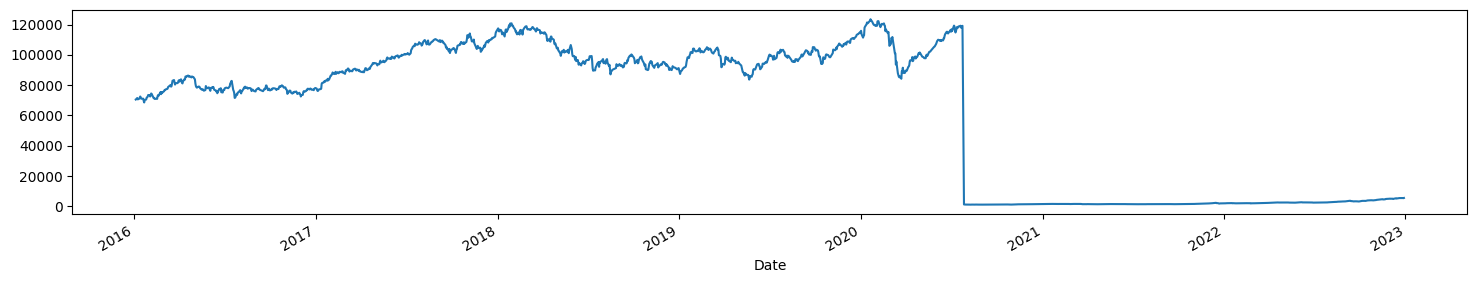

In [82]:
df.plot()

<Axes: xlabel='Date'>

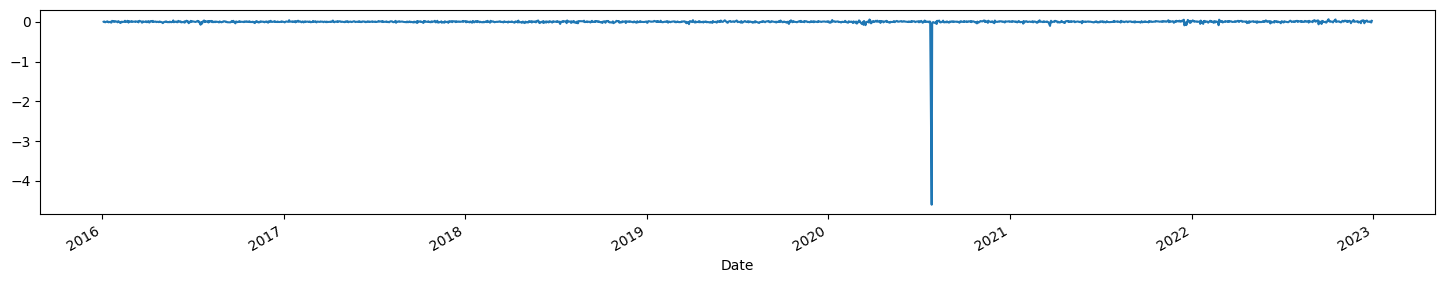

In [83]:
Re.plot()

<Axes: >

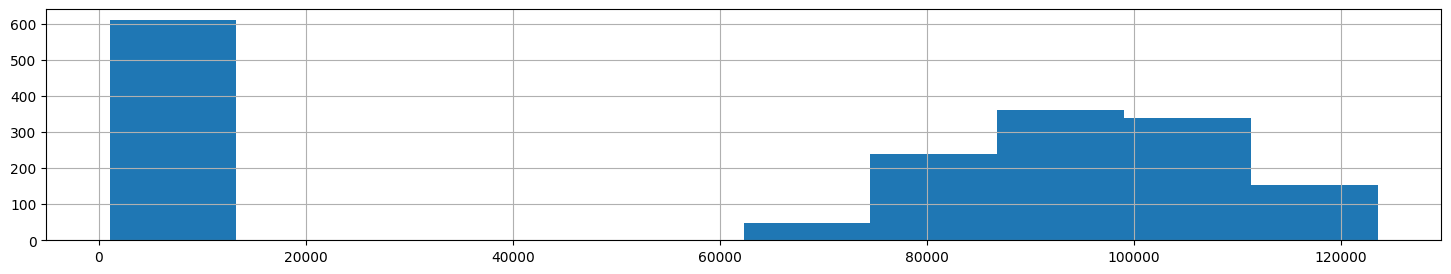

In [84]:
df.hist()

<Axes: >

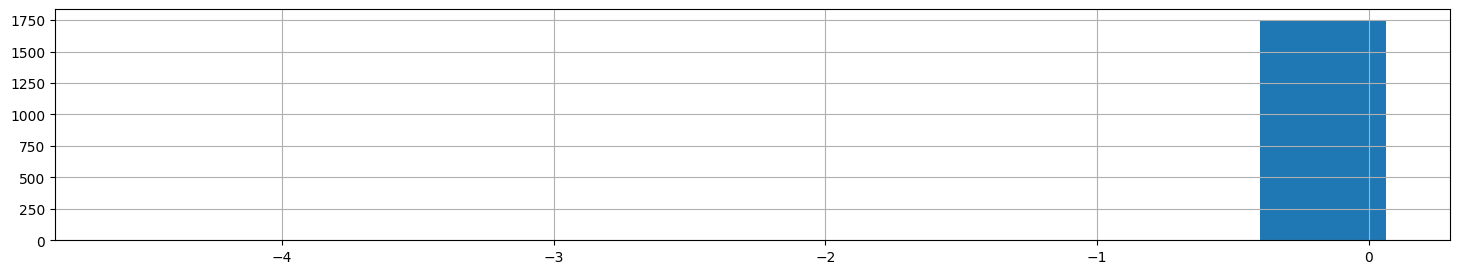

In [85]:
Re.hist()

<Axes: ylabel='Density'>

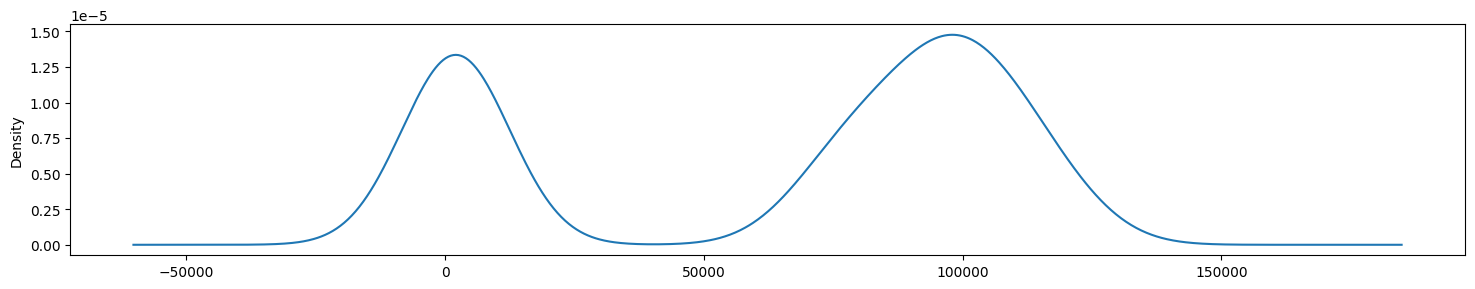

In [86]:
df.plot(kind='kde')

Bu, değerlerin zaman sıralaması olmadan bir çizgisini ifade eder. Bazı doğrusal zaman serisi tahmin yöntemleri, gözlemlerin düzgün bir dağılımını varsayar (örneğin, bir çan eğrisi veya normal dağılım). Bu, istatistiksel hipotez testleri gibi araçlar kullanılarak açıkça kontrol edilebilir. Ancak grafikler, gözlemlerin dağılımını kontrol etmek için hem ham gözlemler üzerinde hem de veri dönüşümü türüne bağlı olarak yapıldıktan sonra kullanılabilecek kullanışlı bir ilk kontrol sağlayabilir.

### Gecikme Dağılım Grafikleri

Zaman serisi modellemesi, bir gözlem ile önceki gözlem arasında bir ilişki olduğunu varsayar. Bir zaman serisindeki önceki gözlemlere gecikmeler denir; önceki zaman adımındaki gözlem gecikme=1 olarak adlandırılır, iki zaman adımı önceki gözlem gecikme=2 vb. olarak adlandırılır. Her bir gözlem ile o gözlemin bir gecikmesi arasındaki ilişkiyi araştırmak için kullanışlı bir grafik türüne dağılım grafiği denir. Pandas'ın tam olarak bunun için gecikme grafiği adı verilen yerleşik bir işlevi vardır. t zamanındaki gözlemi x eksenine ve gecikme=1 gözlemini (t-1) y eksenine çizer.

- Noktalar grafiğin sol alt kısmından sağ üst köşesine doğru çapraz bir çizgi boyunca kümeleniyorsa bu, pozitif bir korelasyon ilişkisi olduğunu gösterir.
- Noktalar sol üstten sağ alta doğru çapraz bir çizgi boyunca kümeleniyorsa bu, negatif bir korelasyon ilişkisi olduğunu gösterir.
- Her iki ilişki de modellenebildiği için iyidir.

Çapraz çizgiye daha yakın olan daha fazla nokta, daha güçlü bir ilişkiye işaret eder ve çizgiden daha fazla yayılma, daha zayıf bir ilişkiye işaret eder. Ortadaki bir top veya olay örgüsüne yayılmış bir ilişki zayıf veya hiç ilişki olmadığını gösterir.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

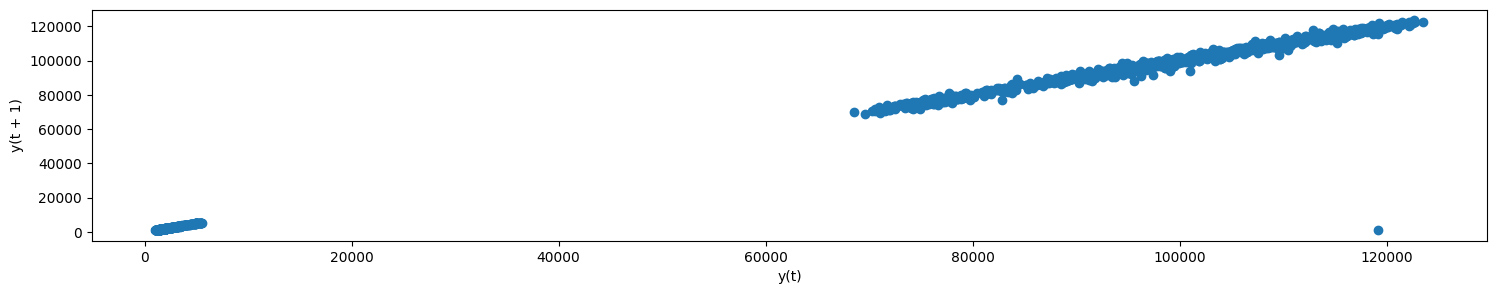

In [87]:
lag_plot(ts)

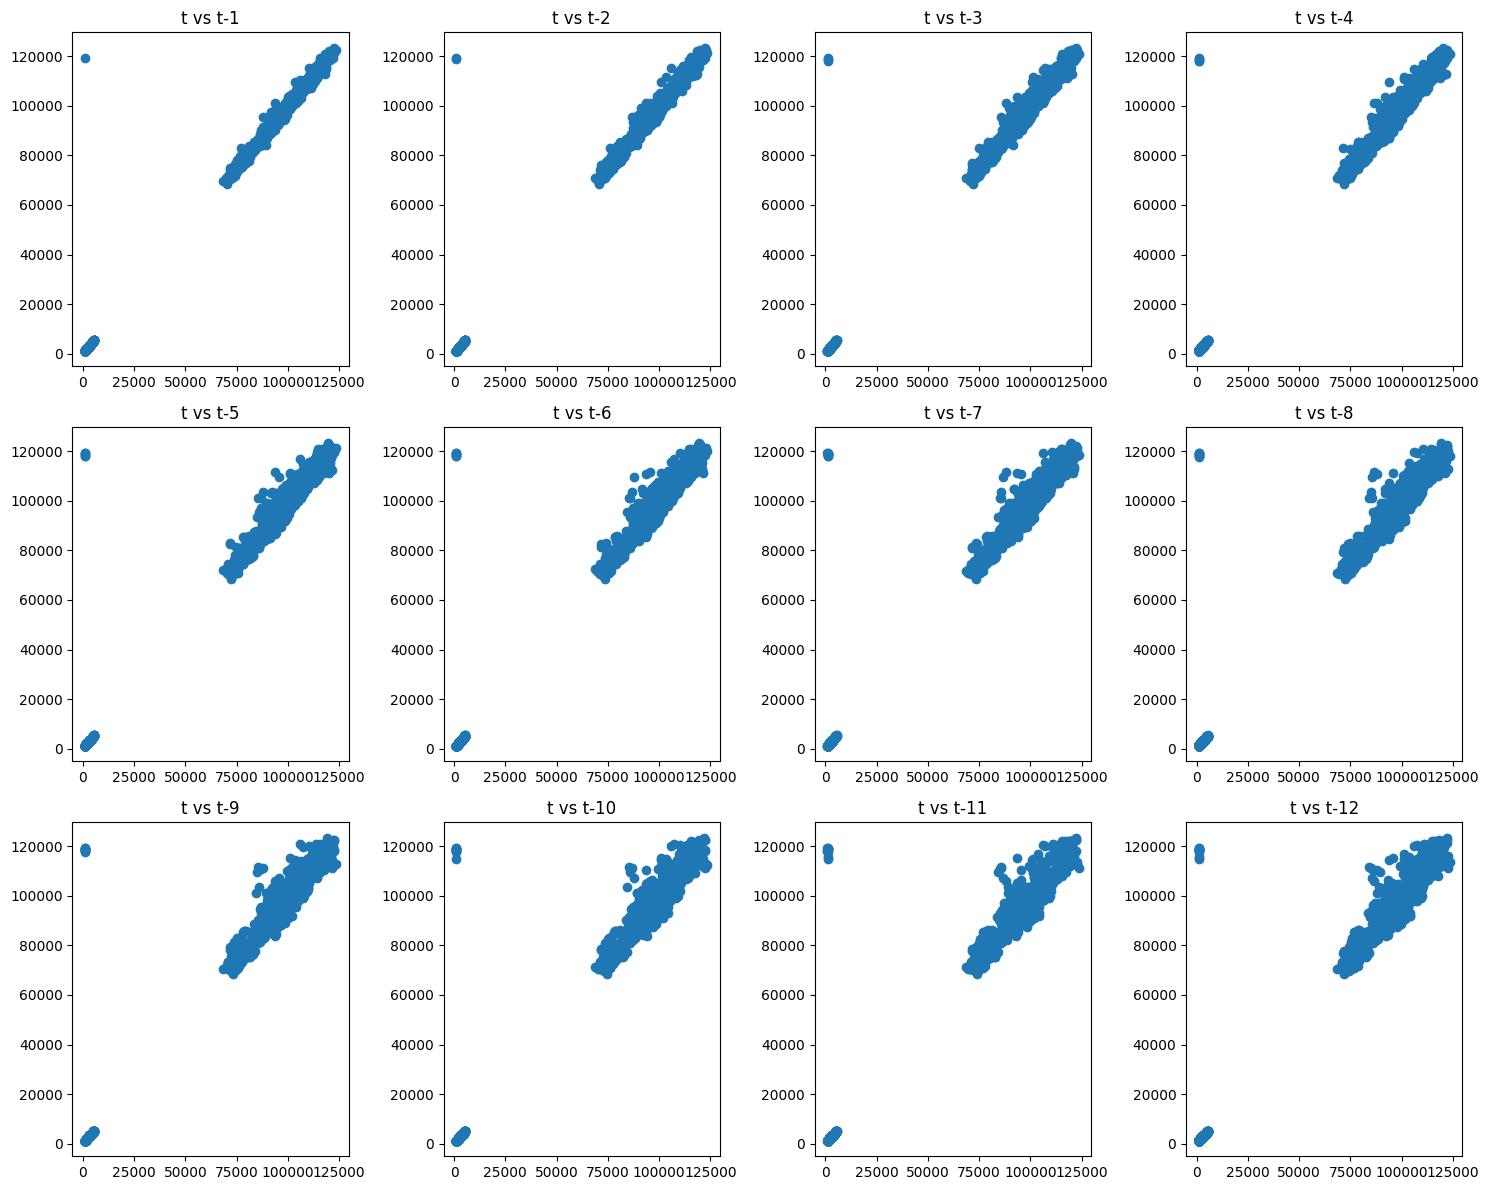

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Birden çok dağılım grafiği oluşturun
values = pd.DataFrame(df.values)
lags = 12
columns = [values]

for i in range(1, (lags + 1)):
    columns.append(values.shift(i))

dff = pd.concat(columns, axis=1)

# İlk sütunu 't' olarak yeniden adlandırın
columns = ['t']
for i in range(1, (lags + 1)):
    columns.append('t-' + str(i))

dff.columns = columns

# Dinamik alt grafik düzenlemesi için GridSpec'i kullanma
rows = (lags + 3) // 4  # Satırları gecikmelere göre dinamik olarak hesaplayın
gs = gridspec.GridSpec(rows, 4)
fig = plt.figure(figsize=(15,12))

for i in range(1, (lags + 1)):
    ax = fig.add_subplot(gs[(i-1) // 4, (i-1) % 4])
    ax.set_title('t vs t-' + str(i))
    ax.scatter(x=dff['t'].values, y=dff['t-'+str(i)].values)

plt.tight_layout()
plt.show()

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

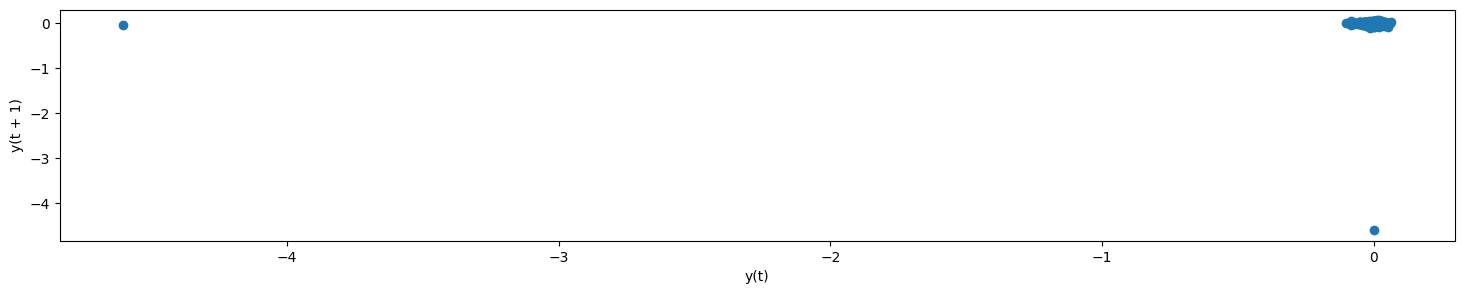

In [89]:
lag_plot(Re)

### Otokorelasyon Grafikleri

Korelogram veya ACF grafiği olarak da bilinen bir otokorelasyon grafiği, bir serinin kendi gecikmeleriyle korelasyonunu görselleştirmek için kullanılır. Finans veya başka herhangi bir alandaki bir fiyat serisine uygulandığında aşağıdaki hususlara ilişkin bilgiler sağlayabilir:

1. **Trend**: Fiyat serisi güçlü bir trende sahipse, ilk birkaç gecikmeye ilişkin otokorelasyonlar önemli ölçüde pozitif olabilir. Bunun nedeni, bir trend serisindeki ardışık değerlerin birbirine, birbirinden daha uzak olan değerlerden daha yakın olma eğiliminde olmasıdır.

2. **Mevsimsellik**: Otokorelasyon fonksiyonundaki düzenli iniş ve çıkış modelleri, fiyat serilerinde mevsimsellik olduğunu gösterebilir. Tutarlı bir model varsa (örneğin, her 12 gecikmede bir zirve), veriler aylıksa bu, yıllık mevsimsel bir etkiyi gösterebilir.

3. **Ortalama Geri Dönüş**: Hisse senedi fiyatları gibi finansal fiyat serileri için, birinci veya ikinci gecikmede negatif bir otokorelasyon varsa, bu bir ortalamaya geri dönüş süreci anlamına gelebilir. Bu, yukarı doğru hareketleri genellikle aşağı doğru hareketlerin takip ettiği veya bunun tersi anlamına gelebilir. Bu özellikle çift ticareti gibi stratejiler bağlamında geçerlidir.

4. **Rastgele Yürüyüş**: İlk gecikmenin (gecikme-1) otokorelasyonunun sıfıra yakın olması ve diğer tüm otokorelasyonların da sıfıra çok yakın olması serinin rastgele bir yürüyüş olabileceğini düşündürmektedir. Hisse senedi fiyatları için durum genellikle böyledir ve seri, seviyelerinden ziyade getirileriyle daha iyi tanımlanır.

5. **Durağanlık**: Az sayıda gecikmeden sonra otokorelasyonda meydana gelen keskin düşüş, serinin durağan olabileceğini (veya dönüşümler yoluyla durağan hale getirildiğini) düşündürmektedir. Durağan olmayan veriler ise otokorelasyonlarda yavaş bir azalma gösterecektir.

6. **Model Tanımlama**: Otoregresif (AR) ve hareketli ortalama (MA) modeller bağlamında, otokorelasyon grafiği modelin sırasının belirlenmesine yardımcı olabilir. Örneğin, bir serinin ACF'si 'p' gecikmesinden sonra kesiliyor ancak kısmi otokorelasyon fonksiyonu (PACF) kademeli olarak sona eriyorsa, o zaman seri bir AR(p) süreci olarak kabul edilebilir.

Bir otokorelasyon grafiğini yorumlamanın biraz dikkat gerektirdiğini unutmamak önemlidir:

- Finans sektöründeki fiyat serileri, etkin piyasa hipotezi nedeniyle çoğu zaman kendi seviyelerinde anlamlı bir otokorelasyon göstermemektedir. Ancak geri dönüşleri veya değişiklikleri kalıplar gösterebilir.
  
- Bir fiyat serisinin getirilerindeki ilk birkaç gecikmedeki önemli bir otokorelasyon, momentumun veya ortalamanın tersine döndüğünü gösterebilir.

- Durağan olmayan seriler için, otokorelasyon birkaç gecikme boyunca anlamlı kalarak bir ilişki hakkında yanlış bir izlenim verebilir.

Finansal fiyat serileriyle çalışırken, fiyatlar yerine getirilerin (veya logaritmik getirilerin) otokorelasyonunu analiz etmek yaygındır çünkü getiriler genellikle ham fiyatlardan daha durağan ve yorumlanabilirdir.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

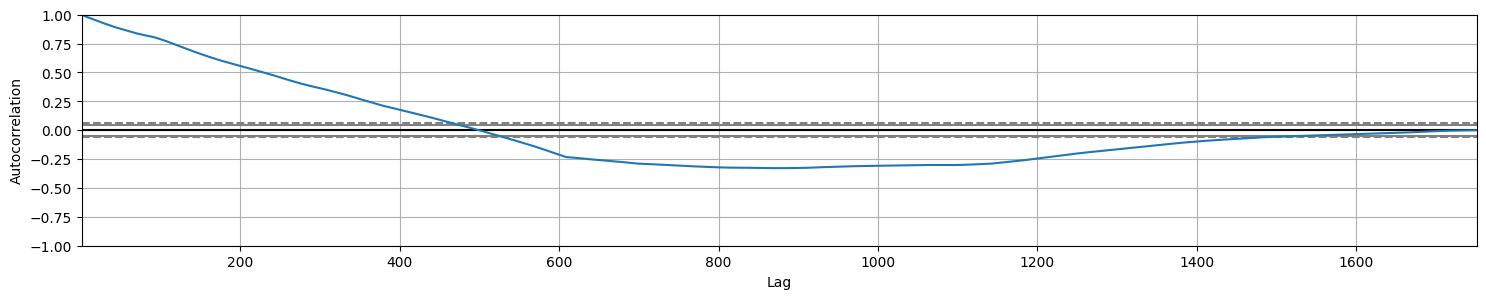

In [90]:
# bir otokorelasyon grafiği oluştur
autocorrelation_plot(df)

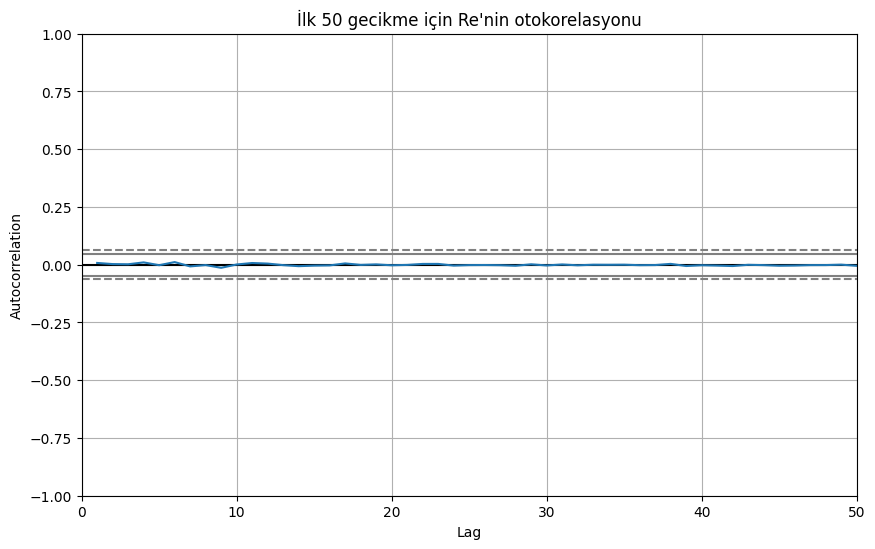

In [91]:
# İlk 50 gecikme için otokorelasyonun grafiğini çizme
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(Re)
plt.xlim([0, 50])  # Gecikmelerin 50 ile sınırlandırılması
plt.title("İlk 50 gecikme için Re'nin otokorelasyonu")
plt.show()


ACF finansal getiri grafiğini yorumlarken dikkate alınması gereken birkaç önemli nokta vardır:

1. **Rastgele Yürüyüş ve Beyaz Gürültü**: Birçok finansal zaman serisi için ham fiyat serileri (hisse senedi fiyatları gibi) genellikle rastgele yürüyüşe yakın bir şeyi takip eder; bu, ardışık değerler arasında hiçbir korelasyon olmadığı anlamına gelir. Bununla birlikte, getirileri hesapladığınızda (örneğin günlük getiriler), seri genellikle daha çok beyaz gürültüye benzer, yani öngörülebilir bir model veya eğilim yoktur. İdeal bir beyaz gürültü serisinde, sıfırdan büyük gecikmeler için tüm otokorelasyonlar sıfıra yakındır.

2. **Önemlilik Düzeyi**: ACF grafiği genellikle anlamlılık düzeyini gösteren yatay çizgiler içerir. Eğer otokorelasyonlar bu sınırlar içerisinde kalıyorsa, bunların genellikle istatistiksel olarak anlamlı olmadığı kabul edilir. Bu sınırların dışına çıkarlarsa, getiri serilerinin tamamen rastgele olmadığını ve otokorelasyona sahip olabileceğini gösteren kanıtlar vardır.

3. **Kısa Vadeli Bağımlılıklar**: Bazı finansal getiri serilerinde, ilk birkaç gecikmede önemli otokorelasyon gözlemleyebilirsiniz. Bunun nedeni şunlar olabilir:
    - **Volatilite Kümelenmesi**: Getirilerdeki büyük değişiklikleri büyük değişiklikler (olumlu veya olumsuz) takip etme eğilimindedir; küçük değişiklikleri ise küçük değişiklikler takip etme eğilimindedir. Bu olgu, finansal verilerde yaygın olarak gözlemlenen volatilite kümelenmesi olarak bilinir.
    - **Piyasa Tepkisi**: Bazen piyasa haberlere veya olaylara gecikmeli tepki verebilir ve bu da kısa vadeli otokorelasyonlara yol açabilir.

4. **Çürüyen Desenler**: ACF grafiğindeki yavaş bir bozulma, uzun bir hafıza süreci veya hareketli ortalama (MA) süreci anlamına gelebilir. Finansal açıdan bu, uzun süreli piyasa tepkilerinin veya eğilimlerinin göstergesi olabilir.

5. **Mevsimsel Etkiler**: ACF grafiğinde düzenli aralıklarla tekrarlanan bir artış varsa, bu durum verilerde mevsimselliğin bir göstergesi olabilir. Ancak finansal günlük getirilerde mevsimsellik nispeten nadirdir. Veriler aylık veya üç aylık olsaydı iş döngüleri veya diğer faktörler nedeniyle mevsimsellik gözlemleyebilirsiniz.

6. **Durağan Olmama**: ACF grafiği çok yüksek başlayıp çok yavaş azalıyorsa bu, serinizin durağan olmadığının işareti olabilir. Durağan olmayan seriler tahminde zorluklar ortaya çıkarabilir ve farklılaştırılması veya dönüştürülmesi gerekebilir.

Özetle, finansal getiriler için ACF grafiği, getirilerin tamamen rastgele olup olmadığı veya potansiyel olarak sömürülebilir modeller olup olmadığı konusunda fikir verebilir. Ancak dikkatli olmak çok önemlidir: Kalıplar tespit edilse bile, bunlar zaman içinde tutarlı kalmayabilir ve işlem maliyetleri veya diğer faktörler, gözlemlenen kalıplara dayalı stratejilerden elde edilen potansiyel kazançları hızla aşındırabilir.

Statsmodels kütüphanesi ayrıca otokorelasyon grafiğinin bir versiyonunu çizgi grafiği olarak sağlar. Grafikler yatayda gecikmeli, korelasyonlar ise dikey eksendedir.

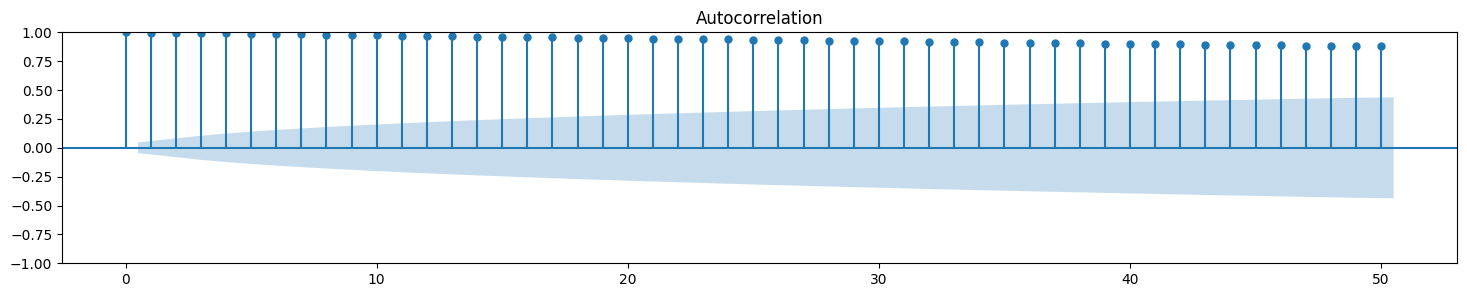

In [92]:
# Bir çizgi grafiği olarak zaman serisinin otokorelasyon grafiği
plot_acf(df, lags=50)
plt.show()

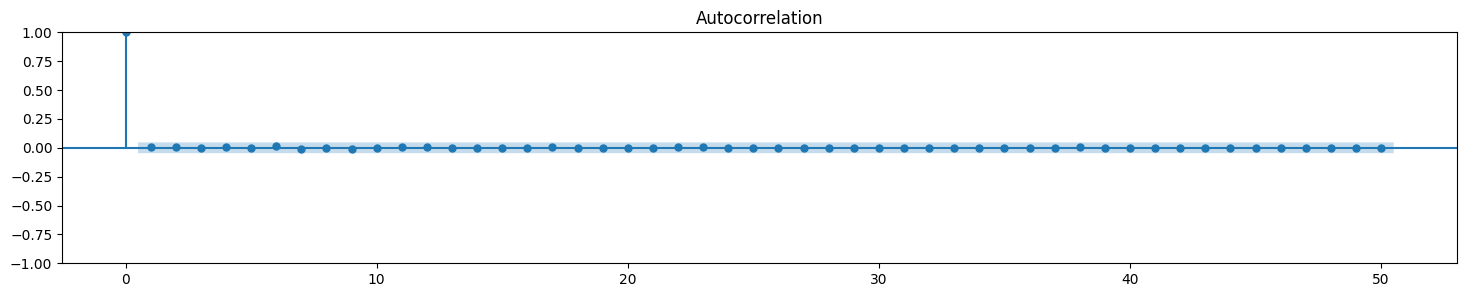

In [93]:
plot_acf(Re, lags=50)
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

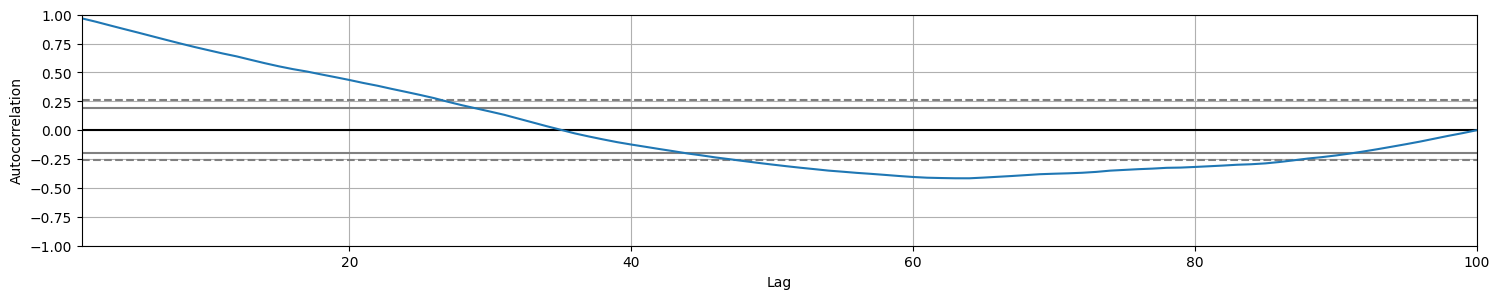

In [94]:
# yalnızca son 100 girişi kullanarak bir otokorelasyon grafiği oluşturun
autocorrelation_plot(df[-100:])

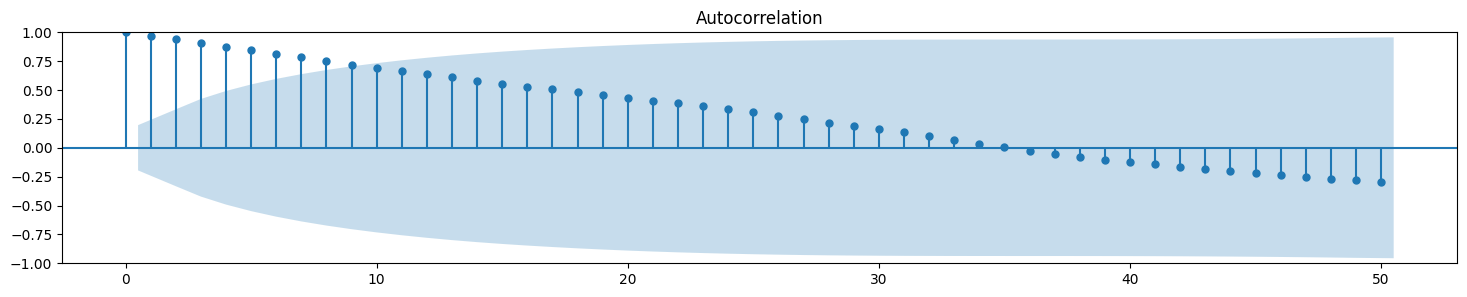

In [95]:
# Bir çizgi grafiği olarak zaman serisinin otokorelasyon grafiği
plot_acf(df[-100:], lags=50)
plt.show()

Kısmi Otokorelasyon Fonksiyonu (PACF) grafiği, bir zaman serisindeki bir gözlem ile önceki zaman adımlarındaki gözlemler arasındaki ilişkiye ilişkin bilgiler sağlar ve araya giren gözlemlerin ilişkileri kaldırılır.

Bir PACF grafiğini nasıl yorumlayacağınız aşağıda açıklanmıştır:

1. **Gecikme Değeri**: X ekseni gecikme değerini temsil eder. Örneğin 1 gecikmesi, bir seri ile önceki değeri arasındaki korelasyonu temsil eder.

2. **Korelasyon**: Y ekseni kısmi otokorelasyonun değerini görüntüler. Korelasyon katsayısına benzer şekilde -1 ile 1 arasında değişir. 1'e yakın bir değer güçlü bir pozitif korelasyonu, -1'e yakın bir değer güçlü bir negatif korelasyonu ve 0'a yakın değerler çok az veya hiç korelasyon olmadığını gösterir.

3. **Güven Aralıkları**: PACF grafiğinde genellikle istatistiksel anlamlılık noktasında çizilmiş yatay çizgiler bulunur. Bu çizgiler genellikle %95 olarak belirlenen güven aralıklarını temsil eder. Bu çizgilerin dışındaki korelasyon değerleri istatistiksel olarak anlamlı kabul edilir.

4. **Önemli Gecikmeler**: PACF grafiğinin üst veya alt güven aralığını geçtiği gecikmeler önemli kabul edilir. Bu önemli gecikmeler, otoregresif terimlerin ARIMA veya AR modellerine dahil edilmesi için kanıt olarak kullanılabilir.

Sonuçların nasıl çıkarılacağı:

- **Keskin Kesim**: ACF daha yavaş (yani daha gecikmeli) azalırken PACF keskin bir kesinti gösteriyorsa, son anlamlı değerle belirtilen sıranın otoregresif (AR) modelinin kullanılması önerilir. gecikme.

- **Kademeli Düşüş**: PACF daha kademeli olarak düşüyorsa ve ACF keskin bir kesime sahipse, bu hareketli ortalama (MA) modelini akla getirir.

- **Karma Davranış**: Hem ACF hem de PACF kademeli bir düşüş gösteriyorsa seri, karma otoregresif hareketli ortalama (ARMA) modeline daha uygun olabilir.

Unutmayın, PACF grafiği otoregresif terimlerin potansiyel sırası hakkında fikir verebilirken, bulmacanın yalnızca bir parçasını oluşturur. Model seçiminde diğer şeylerin yanı sıra alan bilgisi, ACF grafiği ve modeldeki parametrelerin önemi de dikkate alınmalıdır.

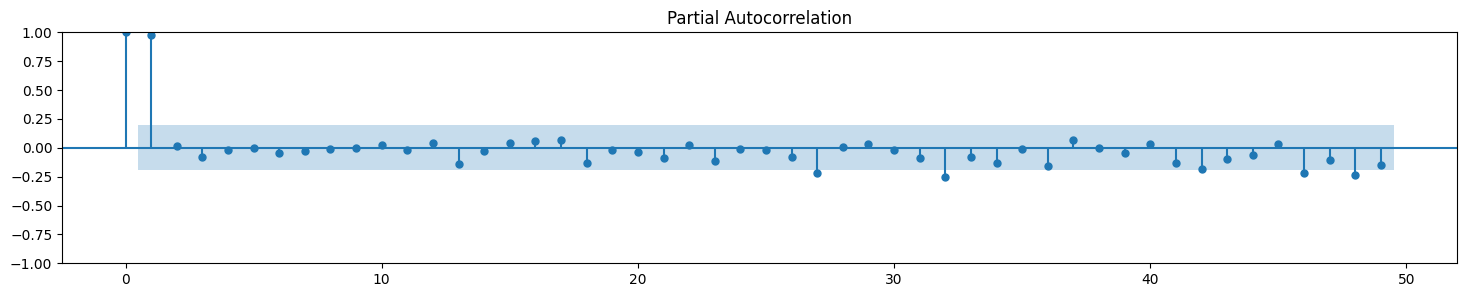

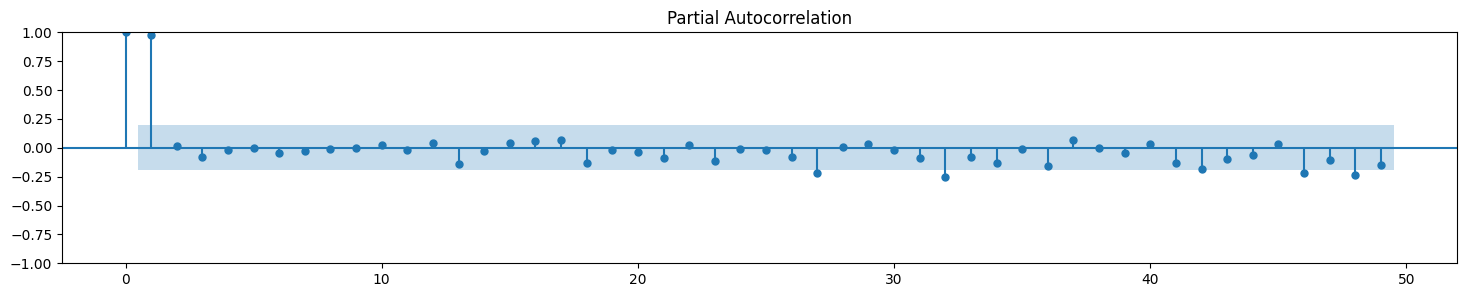

In [96]:
# Bir çizgi grafiği olarak zaman serisinin kısmi otokorelasyon grafiği
plot_pacf(df[-100:], lags=49)

### Hareketli Ortalama Yumuşatma

Hareketli ortalama yumuşatma, zaman serisi tahmininde basit ve etkili bir tekniktir. Veri hazırlama, özellik mühendisliği ve hatta doğrudan tahmin yapmak için kullanılabilir. Yumuşatma, zaman adımları arasındaki ince taneli değişimi ortadan kaldırmak için zaman serilerine uygulanan bir tekniktir. Düzleştirmenin umudu, gürültüyü ortadan kaldırmak ve altta yatan nedensel süreçlerin sinyalini daha iyi ortaya çıkarmaktır.

In [97]:
# tail-rolling ortalama dönüşüm
rolling = df.rolling(window=3)
rolling_mean = rolling.mean()
rolling_mean.head(10)

Date
2016-01-04        NaN
2016-01-05        NaN
2016-01-06   70801.47
2016-01-07   71127.30
2016-01-08   71102.33
2016-01-11   71052.70
2016-01-12   71134.20
2016-01-13   71766.03
2016-01-14   72063.23
2016-01-15   71837.10
Name: Adj Close, dtype: float64

<Axes: xlabel='Date'>

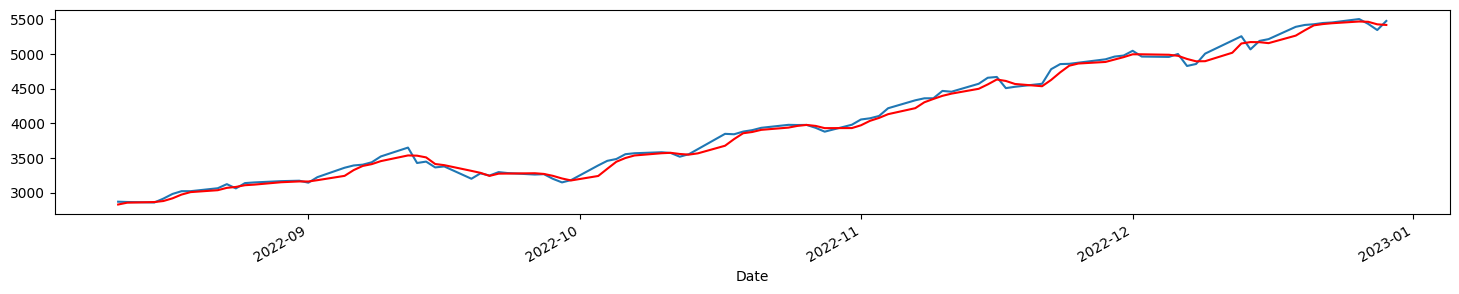

In [98]:
# orijinal ve dönüştürülmüş veri kümesini çizin
df[-100:].plot()
rolling_mean[-100:].plot(color='red')

### Tahmin Olarak Hareketli Ortalama

Hareketli ortalama değeri doğrudan tahmin yapmak için de kullanılabilir. Bu saf bir modeldir ve zaman serisinin trend ve mevsimsellik bileşenlerinin halihazırda kaldırıldığını veya düzeltildiğini varsayar. Tahminler için hareketli ortalama modeli ileriye dönük olarak kolaylıkla kullanılabilir. Yeni gözlemler kullanıma sunuldukça (örneğin günlük olarak), model güncellenebilir ve bir sonraki gün için bir tahmin yapılabilir.

In [99]:
# problemi hazırlamak
X = df.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# testte zaman adımlarında ileri doğru yürüyün
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [100]:
print('RMSE: %.3f' % rmse)

RMSE: 3752.301


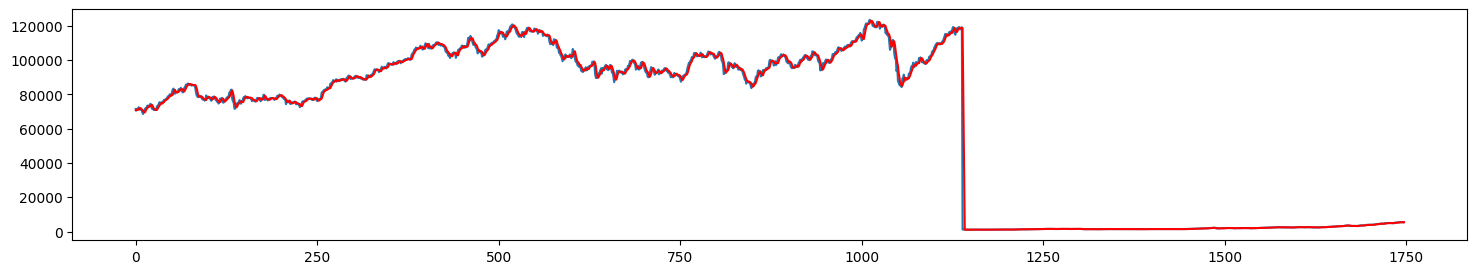

In [101]:
plt.plot(test)
plt.plot(predictions,color="red")
plt.show()

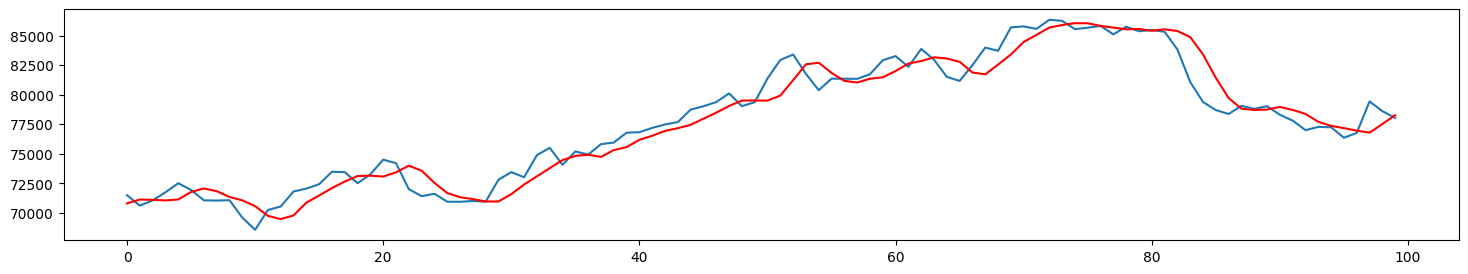

In [102]:
# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()

### Zaman Serisi Bileşenleri

Tahmin yöntemlerini seçmek için yararlı bir soyutlama, bir zaman serisini sistematik ve sistematik olmayan bileşenlere bölmektir.

- **Sistematik:** Zaman serisinin tutarlı veya yinelenen, tanımlanabilen ve modellenebilen bileşenleri.

- **Sistematik Olmayan:** Zaman serisinin doğrudan modellenemeyen bileşenleri.

Belirli bir zaman serisinin seviye, trend, mevsimsellik olmak üzere üç sistematik bileşenden ve gürültü adı verilen sistematik olmayan bir bileşenden oluştuğu düşünülmektedir. Bu bileşenler şu şekilde tanımlanır:


- **Seviye:** Serideki ortalama değer.

- **Trend:** Serideki artan veya azalan değer.

- **Mevsimsellik:** Seride tekrarlanan kısa vadeli döngü.

- **Gürültü:** Serideki rastgele değişim.

Zaman serisi veri setimiz bir trend içerebilir. Trend, seride zaman içinde devam eden artış veya azalıştır. Zaman serisi veri kümenizdeki trend bilgilerini tanımlamanın, modellemenin ve hatta kaldırmanın faydası olabilir.

Zaman serisi veri kümeleri mevsimsel bir bileşen içerebilir. Bu, aylık veya yıllık gibi zaman içinde tekrarlanan bir döngüdür. Bu tekrarlanan döngü, tahmin yaparken modellemek istediğimiz sinyali gizleyebilir ve tahmin modellerimize güçlü bir sinyal sağlayabilir. Mevsimselliğin pek çok türü vardır: günün saati, günlük, haftalık, aylık, yıllık vb. Zaman serisi probleminizde mevsimsellik bileşeninin olup olmadığını belirlemek özneldir. Mevsimselliğin bir yönünün olup olmadığını belirlemeye yönelik en basit yaklaşım, verilerinizi belki farklı ölçeklerde ve trend çizgileri ekleyerek planlayıp gözden geçirmektir.

Mevsimsel bileşenin çıkarıldığı zaman serisine **mevsimsel durağan** denir. Bir veri setinde trend yoksa veya trendi başarılı bir şekilde kaldırırsak, veri setinin **trend durağan** olduğu söylenir.

### Zaman Serisi Verilerinde Durağanlık

Veri üretme sürecinin parametreleri zaman içinde değişmediğinde veriler durağandır.

$x_t$ zaman serisinin ortalaması $E(x_t)=\mu(t)$

$x_t$ zaman serisinin varyansı: $\sigma^2(t)=E[(x_t - \mu(t))^2]$

Eğer $\mu(t)=\mu$ ise bir zaman serisi ortalamada durağandır, yani ortalama zamanla sabittir

$\sigma^2(t)=\sigma^2$ ise zaman serisi varyansta durağandır, yani varyans zamanla sabittir

Zaman serileri trend veya mevsimsel etkiye sahip değilse durağandır. Zaman serileri üzerinden hesaplanan özet istatistikler, gözlemlerin ortalaması veya varyansı gibi zaman içinde tutarlıdır. Bir zaman serisi durağan olduğunda modellenmesi daha kolay olabilir.

İstatistiksel modelleme yöntemleri, etkili olabilmesi için zaman serilerinin durağan olmasını varsayar veya gerektirir. Pek çok istatistiksel test, varsayımlarının derinlerine inerek, test edilen verilerin durağan olmasını gerektirir. Gelecekteki istatistiksel özelliklerin mevcut istatistiksel özelliklerle aynı veya orantılı olduğunu varsayabildiğimiz için, durağan bir zaman serisinin (TS) tahmin edilmesi kolaydır.

#### Durağanlığı Kontrol Edin

Bir zaman serisinin (doğrudan gözlemler, artıklar vb.) durağan olup olmadığını veya durağan olmadığını kontrol etmenin birçok yöntemi vardır.

- ***Grafiklere Bakın:*** Verilerinizin zaman serisi grafiğini inceleyebilir ve belirgin bir trend veya mevsimsellik olup olmadığını görsel olarak kontrol edebilirsiniz.

- ***Özet İstatistikler:*** Sezonlara veya rastgele bölümlere ilişkin verilerinizin özet istatistiklerini inceleyebilir ve bariz veya önemli farklılıkları kontrol edebilirsiniz.

- ***İstatistiksel Testler:*** Durağanlık beklentilerinin karşılanıp karşılanmadığını veya ihlal edilip edilmediğini kontrol etmek için istatistiksel testleri kullanabilirsiniz.

In [103]:
def generate_datapoint(params):
    mu=params[0]
    sigma=params[1]
    return np.random.normal(mu,sigma)

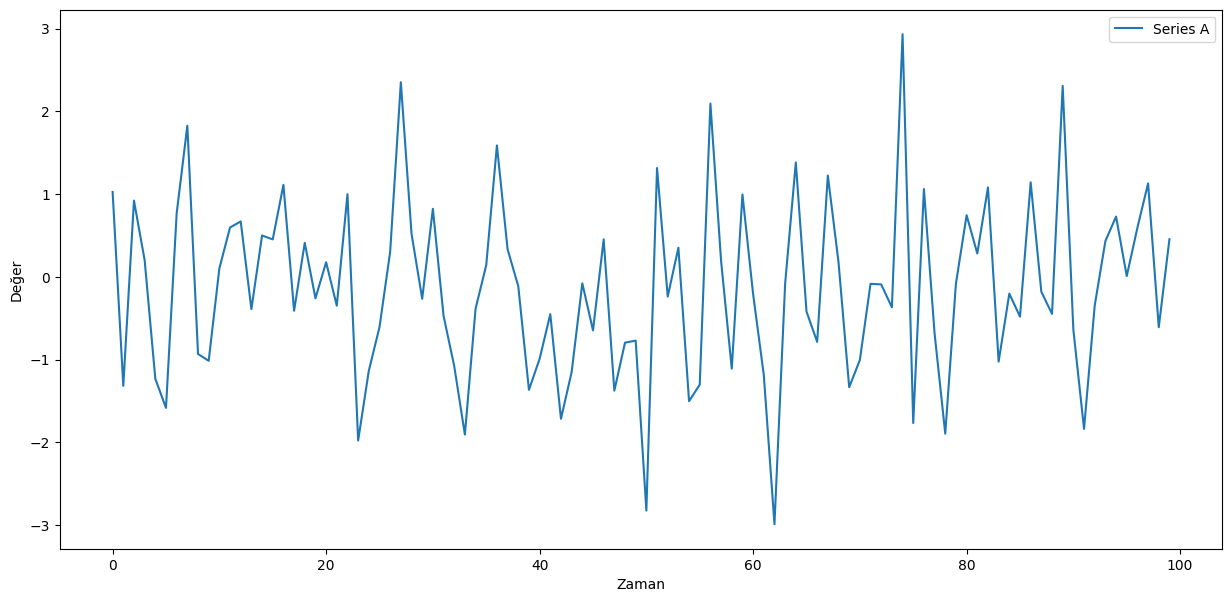

In [104]:
# Parametreleri ve veri noktası sayısını ayarlayın
params=(0,1)
T=100

A=pd.Series(index=range(T))
A.name="A"

for t in range(T):
    A[t]=generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(A)
plt.xlabel("Zaman")
plt.ylabel("Değer")
plt.legend(["Series A"])
plt.show()

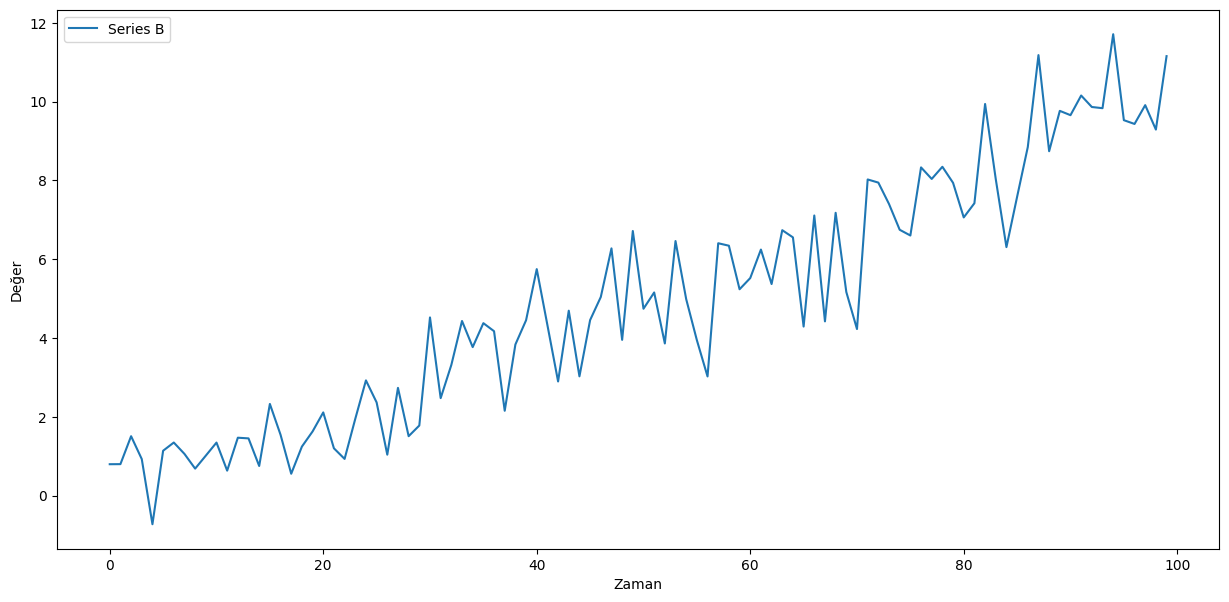

In [105]:
# Veri noktalarının sayısını ayarlayın
T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Artık parametreler zamana bağlı
    # Özellikle serinin ortalaması zamanla değişiyor    
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(B)
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.legend(['Series B'])
plt.show()

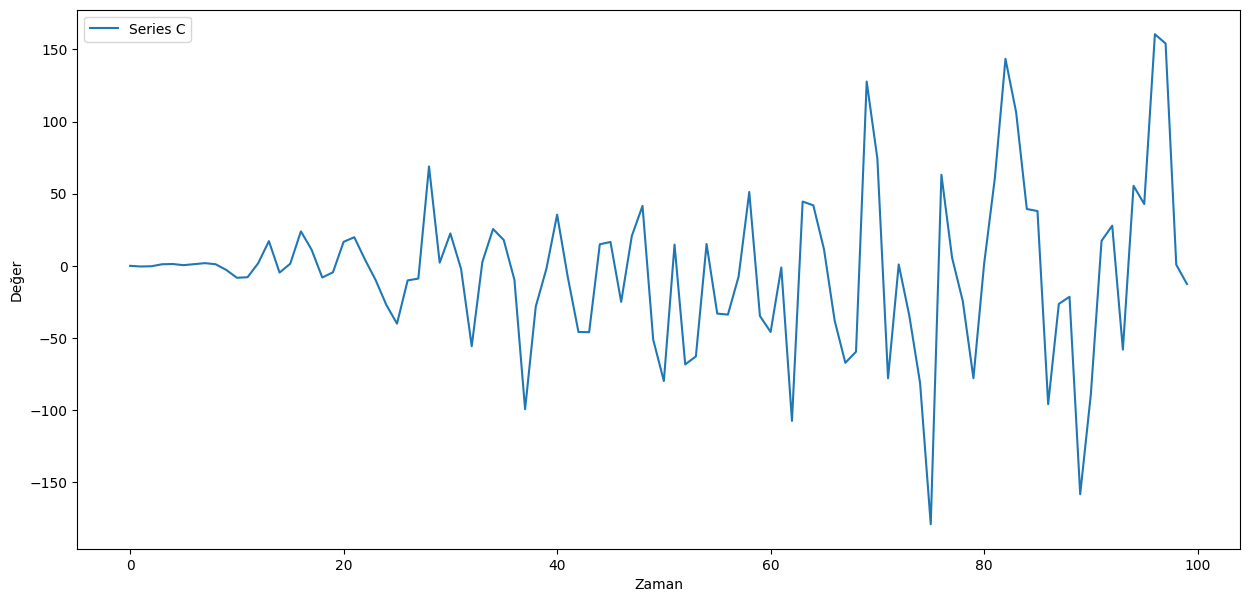

In [106]:
# Veri noktalarının sayısını ayarlayın
T = 100

C = pd.Series(index=range(T))
C.name = 'C'

for t in range(T):
    # Artık parametreler zamana bağlı
    # Özellikle serinin ortalaması zamanla değişiyor
    params = ( 0,t * 1)
    C[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(C)
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.legend(['Series C'])
plt.show()

A serisi sabit parametrelere sahip durağan bir süreçten üretilir, B ve C serileri ise zamanla değişen parametrelere sahip olarak üretilir.

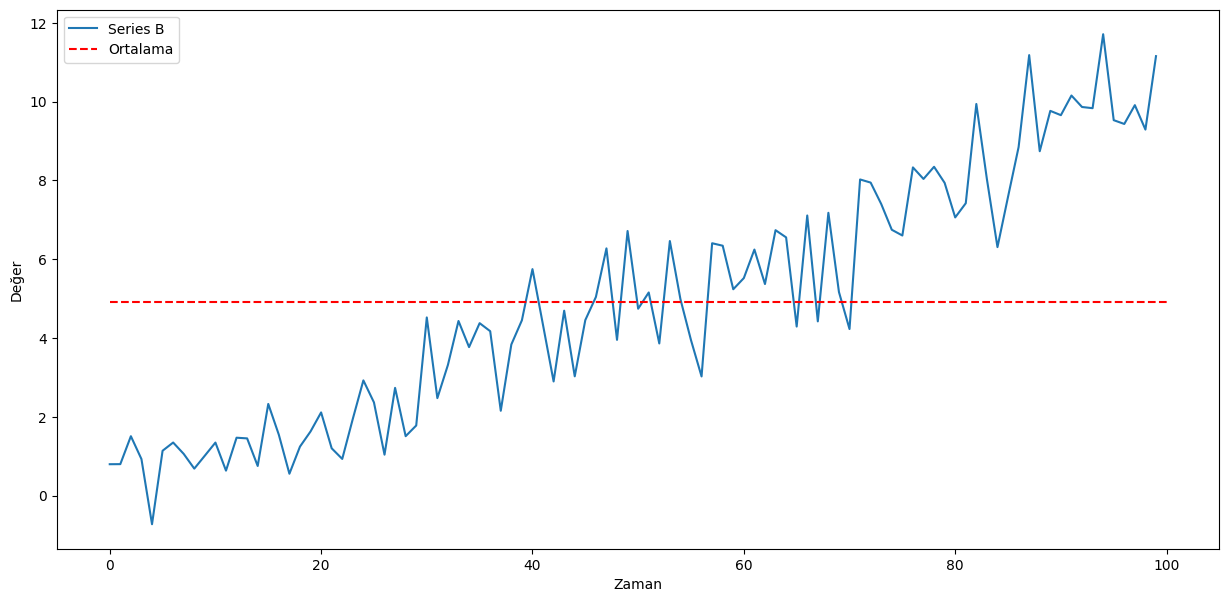

In [107]:
m = np.mean(B)
plt.figure(figsize=(15,7))
plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.legend(['Series B', 'Ortalama'])
plt.show()

Hesaplanan ortalama, bugüne kadarki tüm veri noktalarının ortalamasını gösterecektir, ancak gelecekteki duruma ilişkin herhangi bir tahminde yararlı olmayacaktır. Belirli bir zamanla karşılaştırıldığında anlamsızdır, çünkü farklı zamanlarda farklı durumların bir araya getirilmiş halidir. Bu, durağan olmamanın neden analize zarar verebileceğinin basit ve açık bir örneğidir, pratikte çok daha ince problemler ortaya çıkabilir.

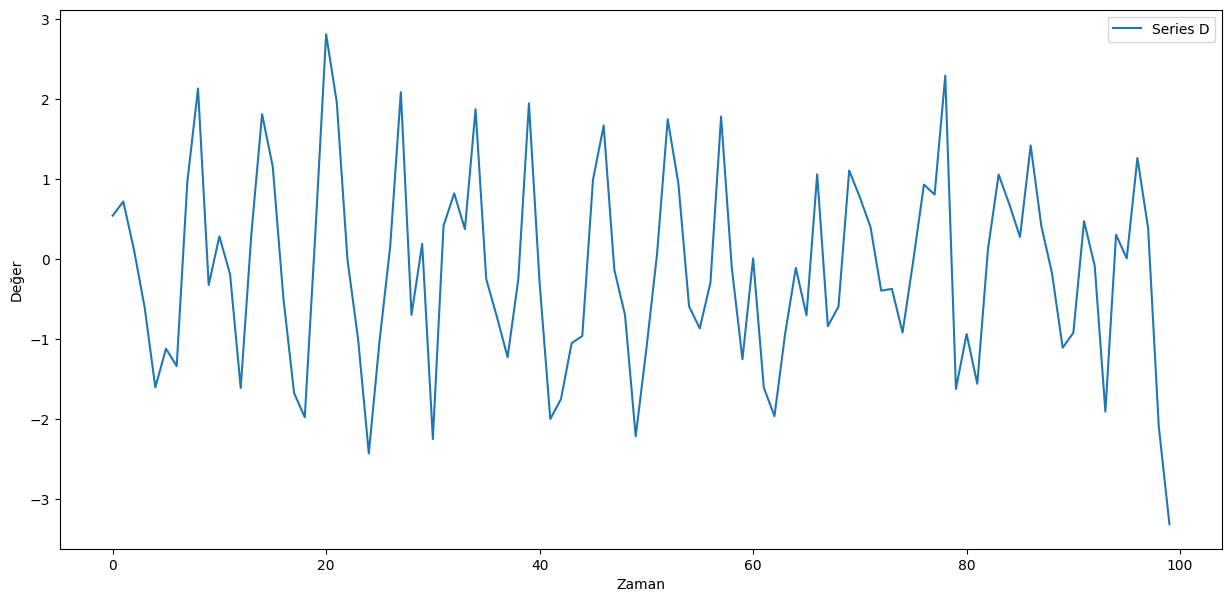

In [108]:
# Veri noktalarının sayısını ayarlayın
T = 100

D = pd.Series(index=range(T))
D.name = 'D'

for t in range(T):
    # Artık parametreler zamana bağlı
    # Özellikle serinin ortalaması zamanla değişiyor
    params = (np.sin(t), 1)
    D[t] = generate_datapoint(params)
plt.figure(figsize=(15,7))
plt.plot(D)
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.legend(['Series D'])
plt.show()

Ortalamanın döngüsel bir hareketini rastgele gürültüden ayırt etmek çok zor olacaktır. Gürültülü veriler ve sınırlı örneklem büyüklüğü üzerinde yapılan uygulamada, bir serinin durağan olup olmadığını ve herhangi bir sapmanın rastgele bir gürültü mü yoksa bir trendin parçası mı olduğunu belirlemek zor olabilir. Her bir durumda test bunun gibi ince etkileri yakalayabilir veya yakalayamayabilir.

## Artırılmış Dickey-Fuller testi

Artırılmış Dickey-Fuller testi, birim kök testi adı verilen bir istatistiksel test türüdür. Birim kök testinin arkasındaki mantık, bir zaman serisinin bir trend tarafından ne kadar güçlü tanımlandığını belirlemesidir. Otoregresif bir model kullanır ve birden fazla farklı gecikme değeri boyunca bir bilgi kriterini optimize eder. Testin sıfır hipotezi, zaman serisinin birim kök ile temsil edilebileceği, durağan olmadığı (zamana bağlı bir yapıya sahip olduğu) yönündedir. Alternatif hipotez (sıfır hipotezini reddeden), zaman serisinin durağan olduğudur.

In [109]:
# fiyat verilerinin durağanlık testini hesaplamak
X = df.values
result = adfuller(X)
print('ADF İstatistiği: %f' % result[0])
print('p-value: %f' % result[1])
print('Kritik Değerler:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF İstatistiği: -1.079572
p-value: 0.723149
Kritik Değerler:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [110]:
# dönüş verilerinin durağanlık testini hesaplayın
X = Re
result = adfuller(X)
print('ADF İstatistiği: %f' % result[0])
print('p-value: %f' % result[1])
print('Kritik Değerler:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF İstatistiği: -41.476834
p-value: 0.000000
Kritik Değerler:
	1%: -3.434
	5%: -2.863
	10%: -2.568


-14,536258 istatistik değerimizin %5'teki -2,862 değerinden küçük olduğunu görebiliriz. Bu, sıfır hipotezini %5'ten daha düşük bir anlamlılık düzeyiyle (yani sonucun istatistiksel bir rastlantı olma ihtimalinin düşük olması) reddedebileceğimizi göstermektedir. Sıfır hipotezinin reddedilmesi, sürecin birim kökü olmadığı, dolayısıyla zaman serisinin durağan olduğu veya zamana bağlı bir yapıya sahip olmadığı anlamına gelir.

## Eşbütünleşme

Artık durağanlığı ve entegrasyon sırasını tartıştığımıza göre eşbütünleşmeyi tartışabiliriz.

Zaman serisinin doğrusal bir kombinasyonu ($X_1$, $X_2$, $\dots$, $X_k$), herhangi bir gerçek sayı kümesi için aşağıdaki şekilde oluşturulan yeni bir $Y$ zaman serisidir $b_1 \dots b_k$

$$Y = b_1X_1 + b_2X_2 + \dots + b_kX_k$$

Bazı zaman serileri kümesi için ($X_1$, $X_2$, $\dots$, $X_k$), eğer tüm seriler $I(1)$ ise ve bunların bazı doğrusal kombinasyonları $I(0)$ ise, zaman serisi kümesinin eşbütünleşik olduğunu söylüyoruz.

Örneğin, $X_1$, $X_2$ ve $X_3$'ın tümü $I(1)$'dır ve $2X_1 + X_2 + 0X_3 = 2X_1 + X_2$, $I(0)$'dır. Bu durumda zaman serileri eşbütünleşiktir.

### Sezgi

Buradaki sezgi, serinin bazı doğrusal kombinasyonları için sonucun çok fazla oto-kovaryanstan yoksun olduğu ve çoğunlukla gürültü olduğudur. Bu, fiyatları eş bütünleşik olan iki varlık bulduğumuz çiftli ticaret gibi durumlarda faydalıdır. Fiyatların $b_1A_1 + b_2A_2$ doğrusal kombinasyonu gürültü olduğundan, $b_1A_1 + b_2A_2$ ilişkisinin geri dönüş anlamına geldiğine bahse girebilir ve buna göre işlem yapabiliriz.

Bunu göstermek için bazı veriler oluşturalım.

In [111]:
# Serinin uzunluğu
N = 100

# Durağan rastgele bir X1 oluşturun
X1 = np.random.normal(0, 1, N)
# Bunu yapmak için entegre edin I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# X1 artı biraz gürültü olan bir X2 yapın
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

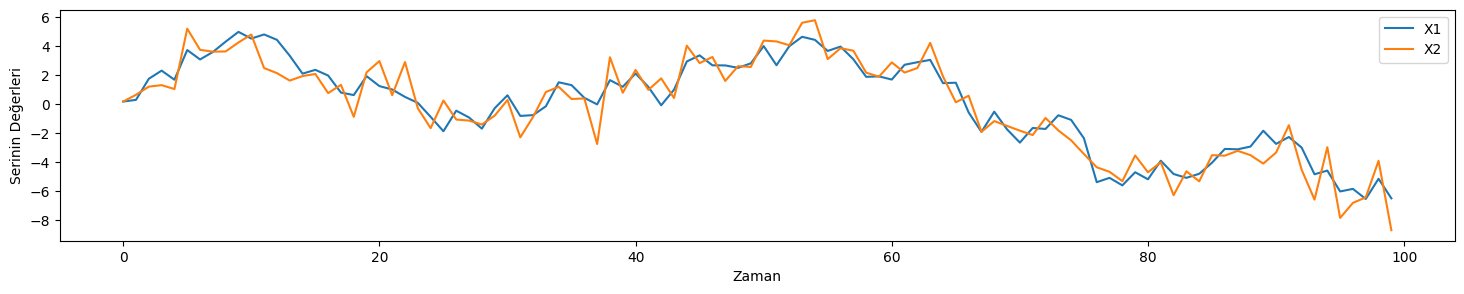

In [112]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Zaman')
plt.ylabel('Serinin Değerleri')
plt.legend([X1.name, X2.name])
plt.show()

$X_2$ yalnızca bir $I(1)$ serisi artı bir miktar durağan gürültü olduğundan, yine de $I(1)$ olmalıdır. Bunu kontrol edelim. Şimdi eşbütünleşmeyi göstermek için $X_1$ ve $X_2$'ın durağan bir doğrusal kombinasyonunu bulmamız gerekecek. $X_2-X_1$ alabiliriz. Geriye kalan tek şey tasarım gereği sabit gürültü olmalıdır. Bunu kontrol edelim.

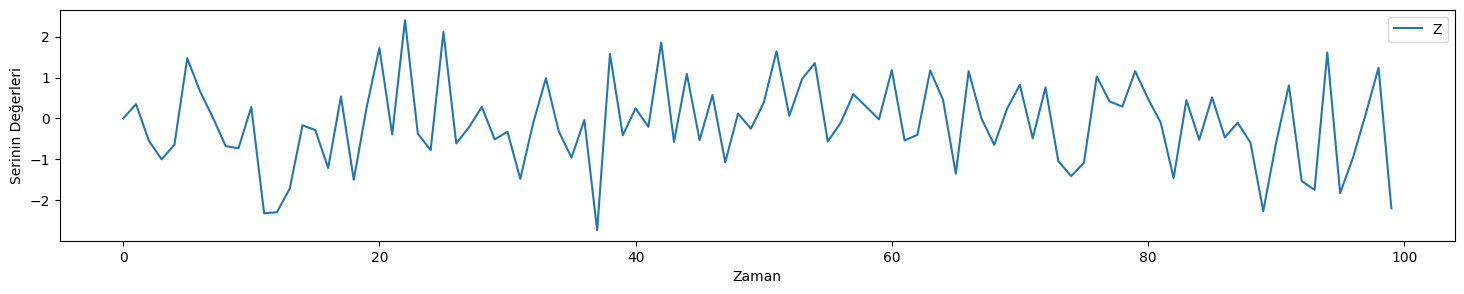

In [113]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Zaman')
plt.ylabel('Serinin Değerleri')
plt.legend(['Z'])
plt.show()

## Modelleri Değerlendirin

Zaman serisi tahmininin amacı geleceğe ilişkin doğru tahminler yapmaktır. Tren-test bölmeleri ve k-katlı çapraz doğrulama kullanmak gibi makine öğreniminde güvendiğimiz hızlı ve güçlü yöntemler, zaman serisi verileri durumunda çalışmaz. Bunun nedeni, problemin doğasında olan zamansal bileşenleri göz ardı etmeleridir.

Zaman serisi tahmininde, modellerin geçmiş veriler üzerindeki bu değerlendirmesine geriye dönük test adı verilir. Makine öğrenimi modellerinizi zaman serisi problemlerinde geriye doğru test etmek için kullanabileceğiniz üç farklı yönteme bakacağız:

1. Gözlemlerin zamansal sırasına saygı gösteren Eğitim-Test ayrımı.
2. Gözlemlerin zamansal sırasına saygı gösteren Çoklu Eğitim-Test bölümleri.
3. Her adımda yeni veri alındığında bir modelin güncellenebildiği İleriye Doğru Doğrulama.

In [114]:
# Bir zaman serisi veri kümesini eğitim-test bölümünü hesaplamak
X= Re
train_size=int(len(X)*0.66)
train,test=X[0:train_size],X[train_size:len(X)]

In [115]:
print("Gözlemler:%d" % (len(X)))
print('Eğitim Gözlemleri: %d' % (len(train)))
print('Gözlemlerin Test Edilmesi: %d' % (len(test)))

Gözlemler:1750
Eğitim Gözlemleri: 1155
Gözlemlerin Test Edilmesi: 595


## Tahmin için Kalıcılık Modeli

Herhangi bir zaman serisi tahmin probleminde bir temel oluşturmak önemlidir. Performanstaki bir temel, diğer tüm modellerin probleminizde gerçekte ne kadar iyi performans göstereceğine dair size bir fikir verir. Burada, daha sonra bu zaman serisi veri kümesinde temel performans düzeyi olarak kullanabileceğimiz bir kalıcılık tahmini geliştireceğiz.

Aşağıdaki adımlar gereklidir:

1. Tek değişkenli veri kümesini denetimli öğrenme problemine dönüştürün.
2. Test donanımı için eğitim ve test veri kümelerini oluşturun.
3. Kalıcılık modelini tanımlayın.
4. Bir tahmin yapın ve temel performansı belirleyin.
5. Örneğin tamamını gözden geçirin ve çıktının grafiğini çizin.

In [116]:
# Gecikmeli veri kümesi oluştur
values = pd.DataFrame(Re.values)
Re2 = pd.concat([values.shift(1), values], axis=1)
Re2.columns = ['t', 't+1']
Re2 = Re2[1:]
Re2.head()

t   t+1
1  0.00  0.01
2  0.01  0.00
3  0.00 -0.01
4 -0.01  0.01
5  0.01  0.01

In [117]:
# train ve test setlerine bölünmüş
X = Re2.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [118]:
# kalıcılık modeli
def model_persistence(x):
    return x

In [119]:
# ileriye dönük doğrulama
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [120]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.024


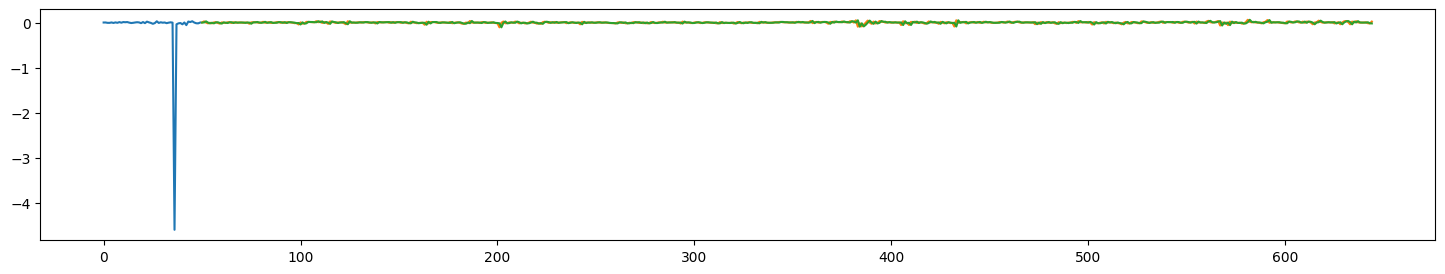

In [121]:
# tahminleri ve beklenen sonuçları test verileri üzerinde çizin
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions])

## Artık Tahmin Hatalarını Görselleştirin

Bir zaman serisi tahmin problemindeki tahmin hatalarına artık hatalar veya artıklar adı verilir. Artık hata, beklenen sonuçtan tahminin çıkarılmasıyla hesaplanır. Zaman serisi tahmin probleminizdeki kalan hataların dikkatli bir şekilde araştırılması, size tahmin modeliniz hakkında çok şey söyleyebilir ve hatta iyileştirmeler önerebilir.

İlk çizim, zaman içindeki artık tahmin hatalarına bir çizgi çizimi olarak bakmaktır. Grafiğin 0 değeri civarında rastgele olmasını ve herhangi bir eğilim veya döngüsel yapı göstermemesini bekleriz.

In [122]:
# Yukarıdaki kalıcılık modelinden kalanları hesaplayın
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

<Axes: >

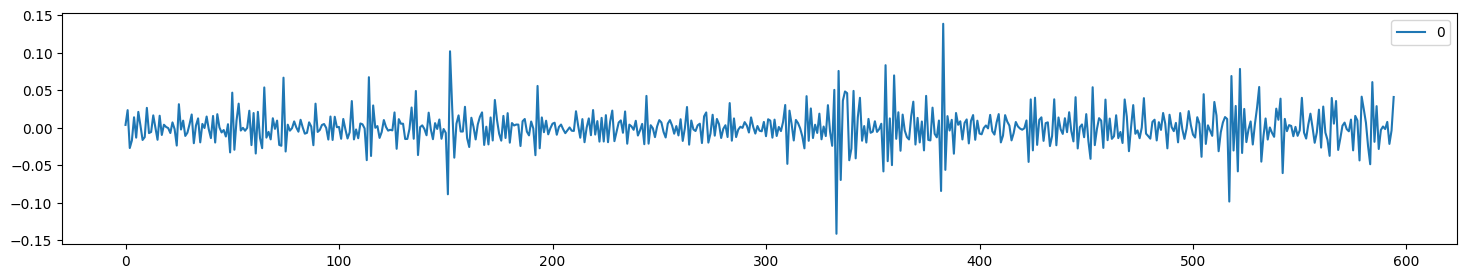

In [123]:
# arsa artıkları
residuals.plot()

Artık hatalara ilişkin özet istatistikler hesaplayabiliriz. Öncelikle artık hataların ortalama değeriyle ilgileniyoruz. Sıfıra yakın bir değer, tahminlerde herhangi bir sapma olmadığını, pozitif ve negatif değerler ise yapılan tahminlerde pozitif veya negatif bir sapma olduğunu gösterir. Tahminlerdeki bir önyargının bilinmesi, kullanım veya değerlendirme öncesinde tahminlerde doğrudan düzeltilebileceği için faydalıdır.

In [124]:
residuals.describe()

0
count 595.00
mean    0.00
std     0.02
min    -0.14
25%    -0.01
50%    -0.00
75%     0.01
max     0.14

array([[<Axes: title={'center': '0'}>]], dtype=object)

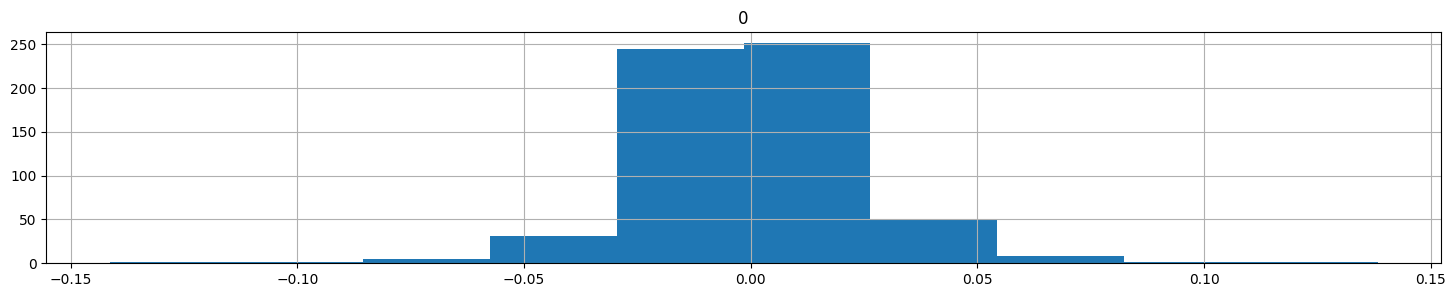

In [125]:
residuals.hist()

<Axes: ylabel='Density'>

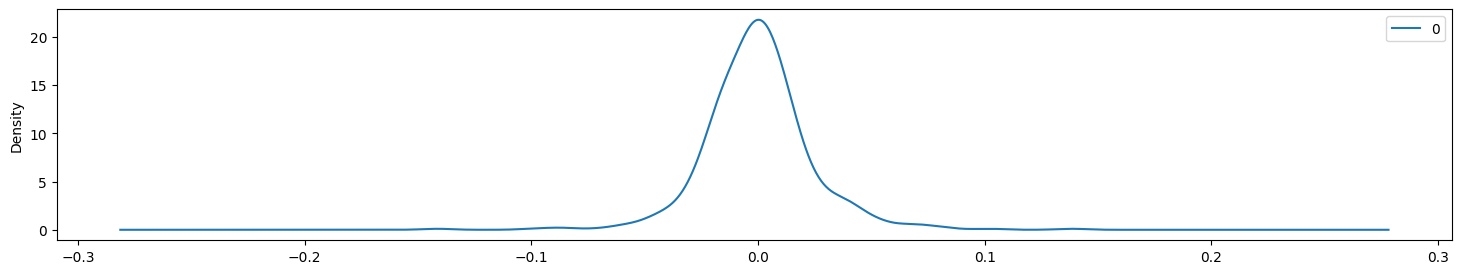

In [126]:
residuals.plot(kind='kde')

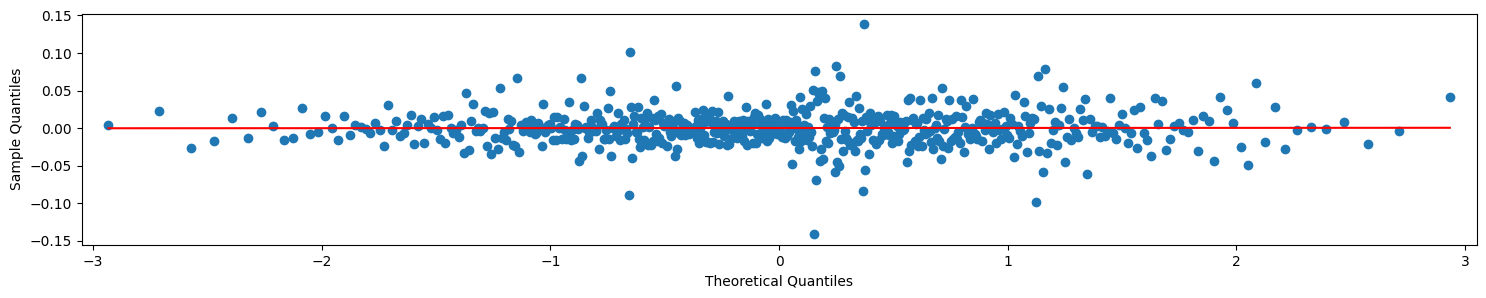

In [127]:
qqplot(residuals, line='r')
plt.show()

### Artık Otokorelasyon Grafiği

Artıklar arasında herhangi bir korelasyon olmasını beklemiyoruz. Bu, otokorelasyon puanlarının anlamlılık eşiğinin altında olmasıyla gösterilebilir (grafik üzerinde kesikli ve noktalı yatay çizgiler). Artık grafiğindeki önemli bir otokorelasyon, modelin, otoregresyon adı verilen, gözlemler ve gecikmeli gözlemler arasındaki ilişkiyi birleştirme konusunda daha iyi bir iş çıkarabileceğini göstermektedir.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

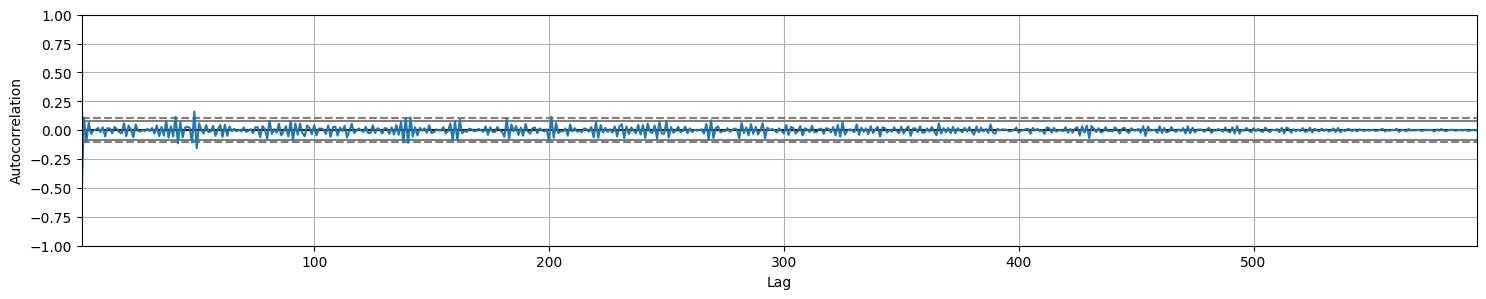

In [128]:
autocorrelation_plot(residuals)

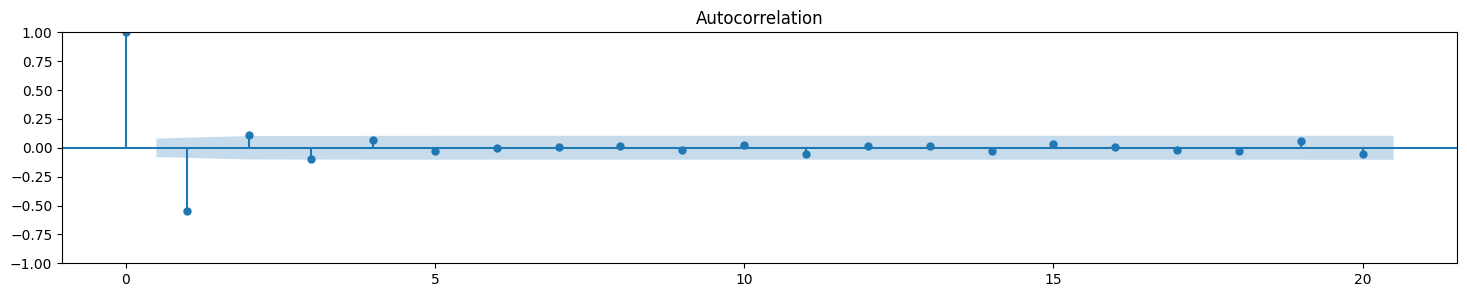

In [129]:
# çizgi grafiği olarak artıkların otokorelasyon grafiği
plot_acf(residuals, lags=20)
plt.show()

## Rassal Yürüyüş
Rassal yürüyüş, bir zaman serisi modelidir ve bu modelde zaman serisi değişkeninin değeri her bir zaman adımında eşit olasılıkla artar veya azalır (yukarı veya aşağı adım atar); yani mevcut gözlemin beklenen değeri önceki gözlemle aynıdır. Aşağıda resmi olarak tanımlanmıştır:

$$x_t=x_{t-1}+w_t$$

Burada $w_t$ kesirli beyaz gürültü serisidir. $$E[x_t]=x_{t-1}$$

Bu, modellediğimiz zaman serisi rassal yürüyüş ise, bu tahmin edilemez demektir, çünkü bunlar tamamen rastgele yürüyüşlerdir.
Rassal yürüyüşün önemi, rassal yürüyüşün durağan olmadığıdır, çünkü rassal yürüyüşün ortalama değeri hala sıfırdır, ancak kovaryans aslında zaman bağımlıdır. Özellikle, kovaryans, varyansın zamanla çarpılmış haliyle eşittir. Dolayısıyla, zaman arttıkça varyans da artar.

Hadi bir rassal yürüyüş simüle edelim.

In [130]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Zaman Serisi Analiz Grafikleri')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

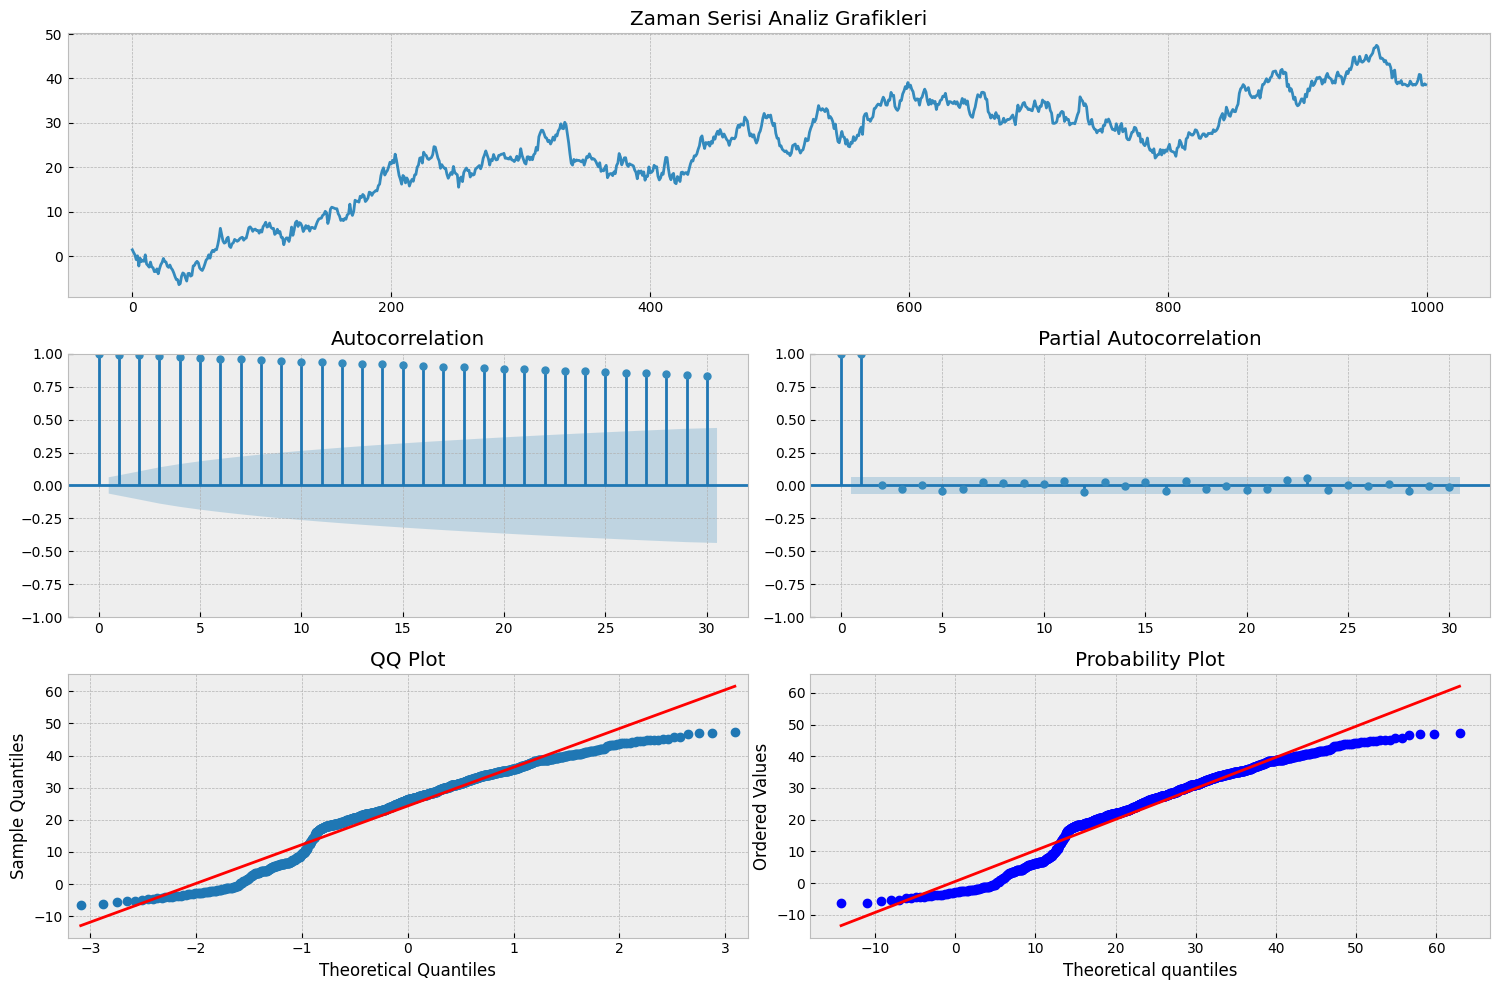

In [131]:
# Sürüklenmeden Rastgele Yürüyüş

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Açıkçası bizim TS'miz sabit değil. Rastgele yürüyüş modelinin simüle edilmiş verilerimize uygun olup olmadığı nasıl kontrol edilir? Sahibiz

$$x_t - x_{t-1} = w_t$$

, burada $w_t$ ayrı bir beyaz gürültü serisidir.
Rastgele yürüyüş serimizin ilk farkları beyaz gürültü sürecine eşit olmalıdır!

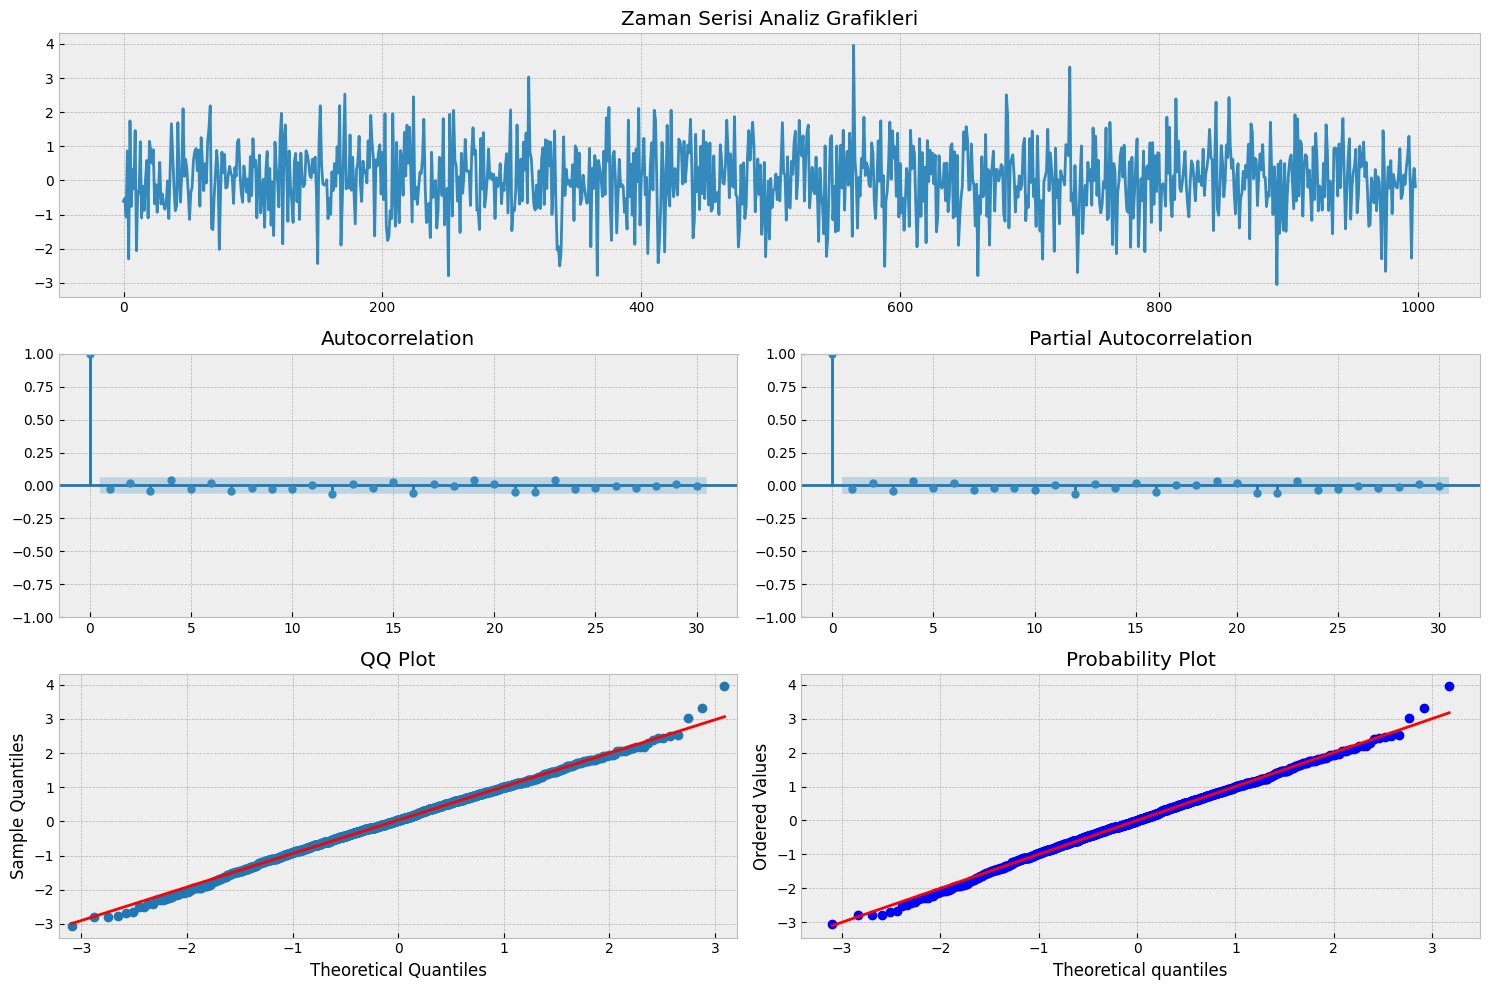

In [132]:
# Simüle edilmiş Rastgele Yürüyüş serisinin ilk farkı
_ = tsplot(np.diff(x), lags=30)

Beklendiği gibi, fark aslında beyaz gürültüdür.
Şimdi rastgele yürüyüş modelimizi bazı gerçek finansal verilere uygulayalım.

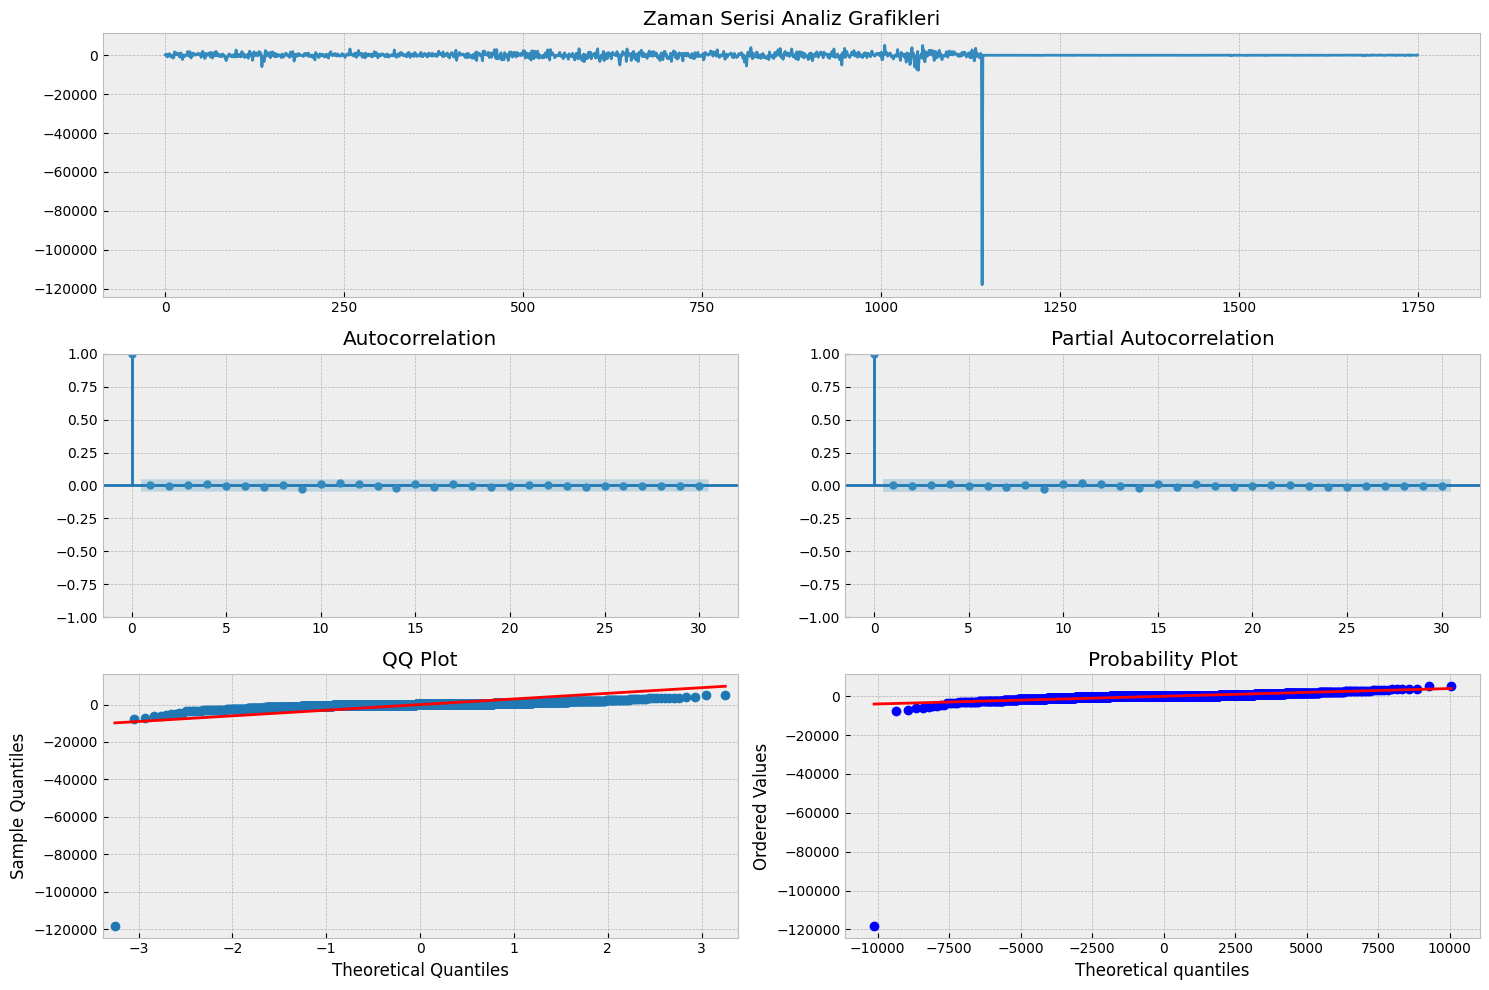

In [133]:
# SPX fiyatlarının ilk farkı
_ = tsplot(np.diff(df), lags=30)

Beyaz gürültüye oldukça benziyor, değil mi? Bununla birlikte, ACF ve PACF grafiklerinde bazı önemli seri korelasyonların olduğu görülmektedir. Ayrıca QQ ve Olasılık grafiklerinin şekline de dikkat edin. Bu durum sürecin normale yakın ancak kuyruklarının ağır olduğunu gösteriyor. Bu, S&P 500'ün fiyatını açıklayacak daha iyi modellerin olması gerektiği anlamına geliyor.

## Doğrusal Modeller

Doğrusal modeller, diğer adıyla trend modelleri, düz bir çizgi kullanılarak grafiği çizilebilen bir TS'yi temsil eder. Temel denklem:

$$x_{t} = a_0+a_1 t + b$$

Zaman serisinin değeri, $a_0, a_1$ ve zaman katsayıları tarafından belirlenir. Buna bir örnek, bir şirketin satışlarının her adımda aynı miktarda artması olabilir. Hiptik bir örnek olarak, hisse senedi fiyatı başlangıçta 100$ olan ve her adımda 50 sent artan bir şirketi düşünün.

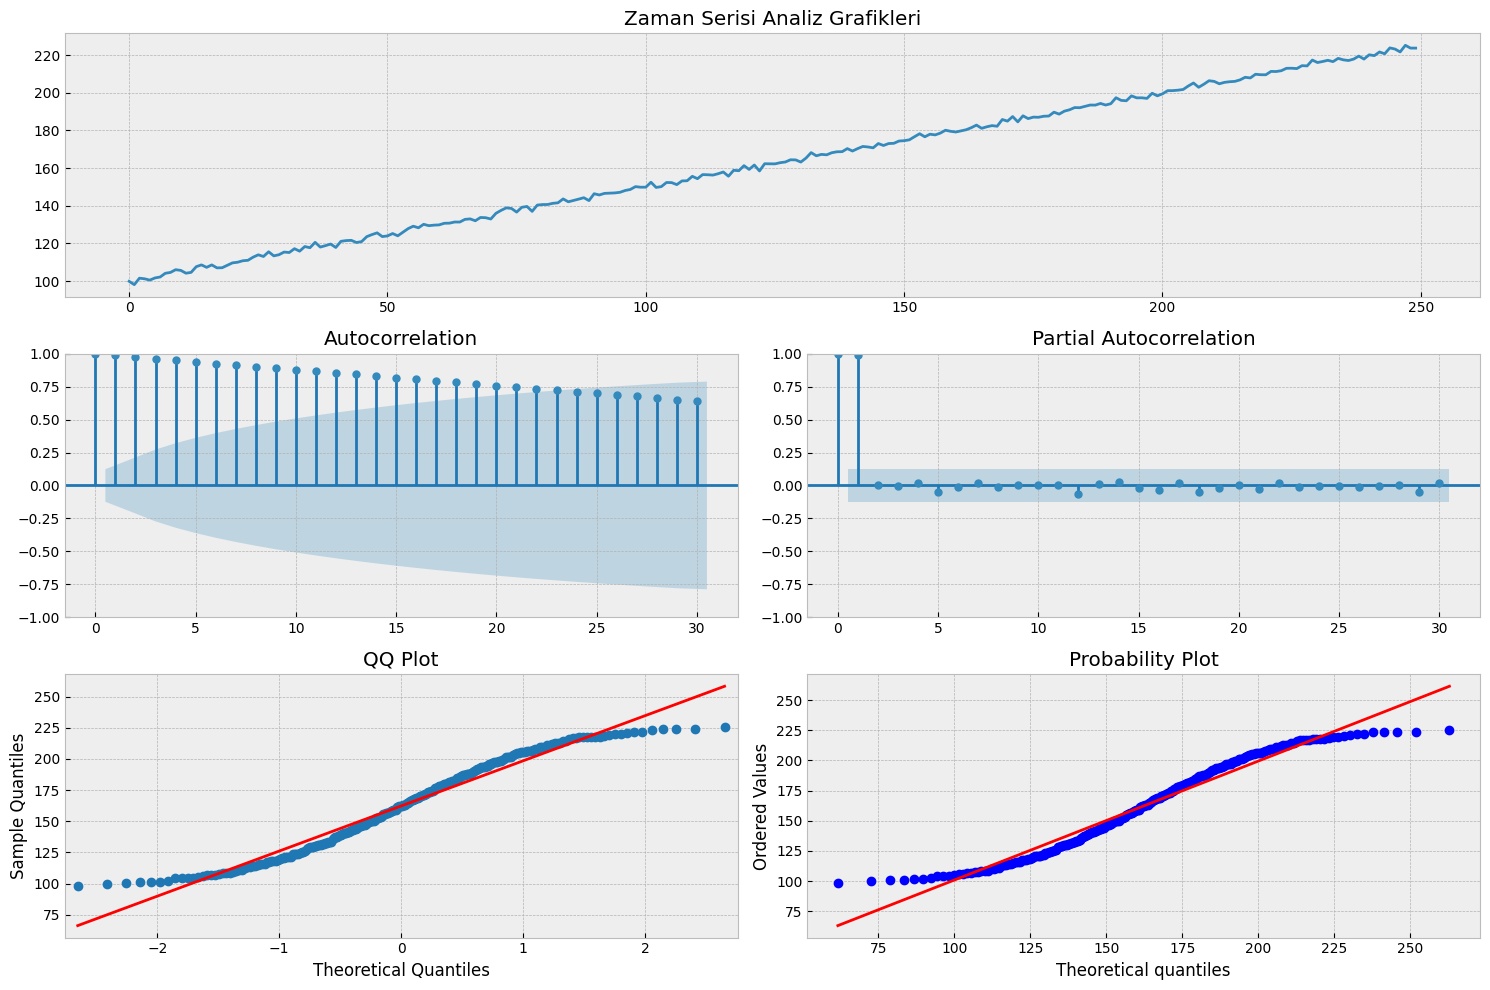

In [134]:
# doğrusal eğilimi simüle et

w = np.random.randn(250)
x = np.empty_like(w)

a0 = 100.
a1 = 0.5
for t in range(len(w)):
    x[t] = a0 + a1*t + w[t]
    
_ = tsplot(x, lags=30)

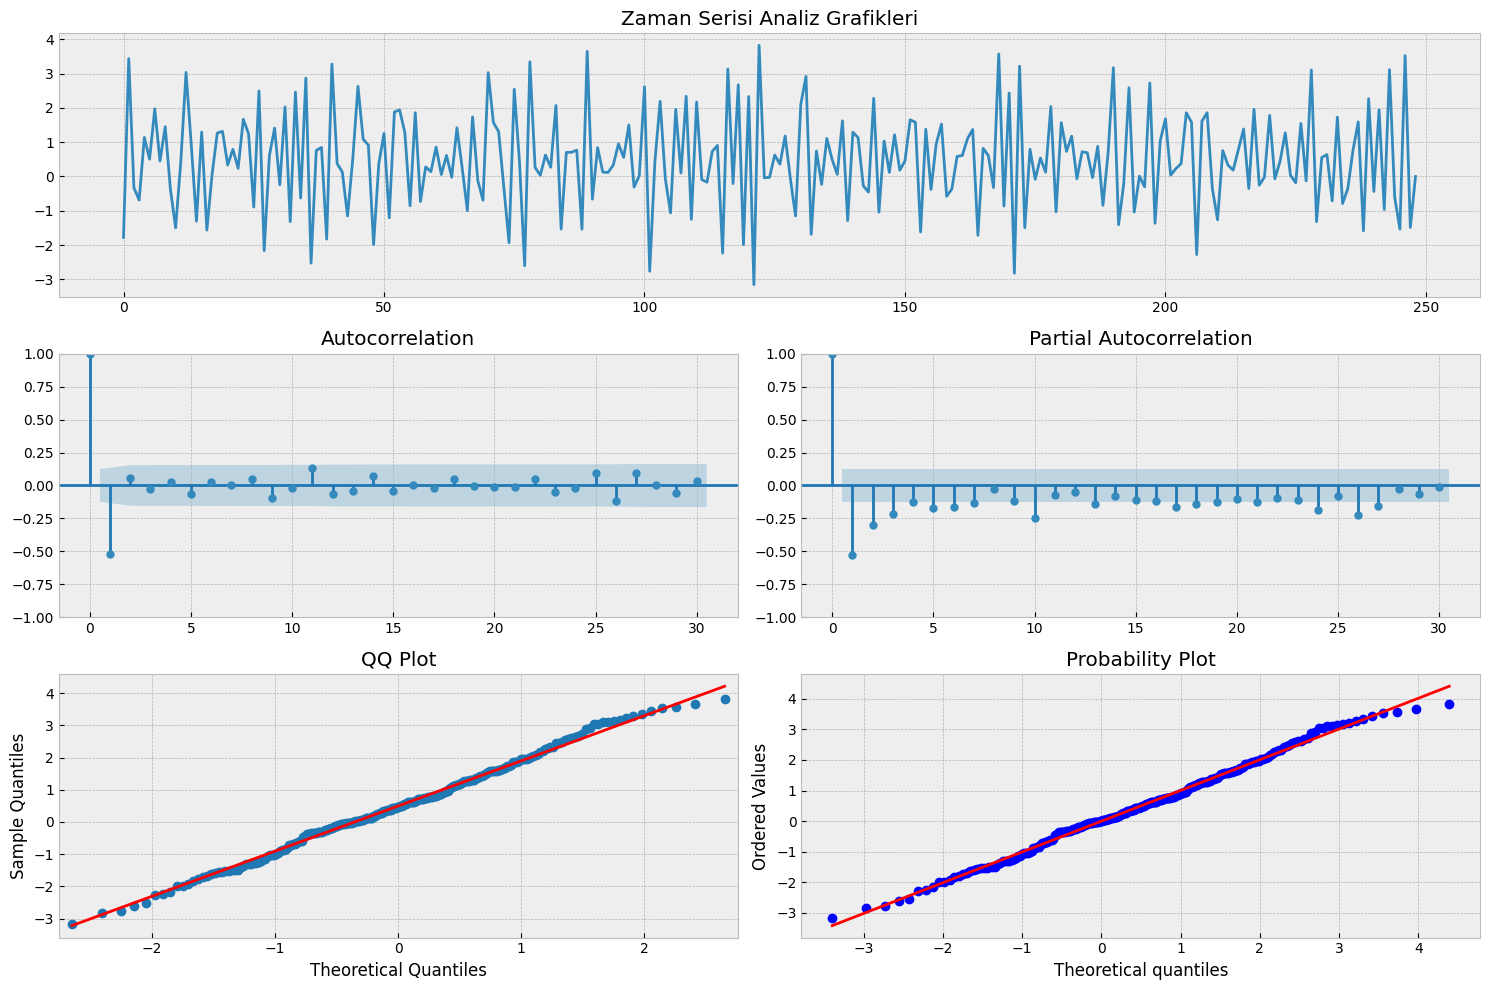

In [135]:
# Simüle edilmiş fiyatların ilk farkı
_ = tsplot(np.diff(x), lags=30)

Burada modelin artıklarının korelasyonlu olduğunu görebiliriz. Dağılım yaklaşık olarak normal olmasına rağmen, tahminlerde bulunmak için bu modeli kullanmadan önce seride mevcut olan belirgin otokorelasyonu (1. gecikmedeki anlamlı değer) hesaba katmamız ve ortadan kaldırmamız gerekir. PACF'nin gecikme 1'deki önemi, otoregresif bir modelin uygun olabileceğini gösterir.

## Otoregresyon Modeli ile Tahmin Yapma

Otoregresyon, bir sonraki zaman adımındaki değeri tahmin etmek için önceki zaman adımlarındaki gözlemleri bir regresyon denklemine girdi olarak kullanan bir zaman serisi modelidir. Bir dizi zaman serisi probleminde doğru tahminler yapılmasını sağlayabilecek çok basit bir fikirdir. Bir otoregresyon modeli, mevcut ve önceki zaman adımlarındaki gözlemlerin bir sonraki zaman adımındaki değeri tahmin etmede faydalı olduğu varsayımını yapar.

Otoregresyon modeli, gecikmeli değişkenleri girdi değişkenleri olarak kullanan doğrusal bir regresyon modelidir. Statsmodels kütüphanesi, istatistiksel testleri kullanarak uygun bir gecikme değerini otomatik olarak seçen ve doğrusal bir regresyon modelini eğiten bir otoregresyon modeli sağlar. AR sınıfında sağlanır.

### p $AR(p)$ sırasının otoregresif modelleri

Otoregresif model, rastgele yürüyüşün basit bir uzantısıdır. Esasen önceki terimlere doğrusal olarak bağlı olan bir regresyon modelidir:

$$x_t = \alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t = \sum_{i=1}^{p} t_i\alpha_ix_{t-i}+w_t$$

Bu, "p" dereceli bir AR modelidir; burada $p$, model içinde kullanılan önceki (veya gecikmeli) terimlerin sayısını temsil eder, $\alpha_i$ katsayıdır ve $w_t$ beyaz gürültü terimidir. $\alpha_1$'ın 1'e eşit olduğu bir AR(1) modelinin rastgele bir yürüyüş olduğunu unutmayın!

AR(p) modelinin en önemli yönlerinden biri her zaman durağan olmamasıdır. Belirli bir modelin durağanlığı parametrelere bağlıdır. Örneğin, $\alpha_1$ = 1 olan bir AR(1) modeli rastgele bir yürüyüştür ve dolayısıyla durağan değildir.

In [136]:
# veri kümesini böl
X = Re.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

<Axes: xlabel='Date'>

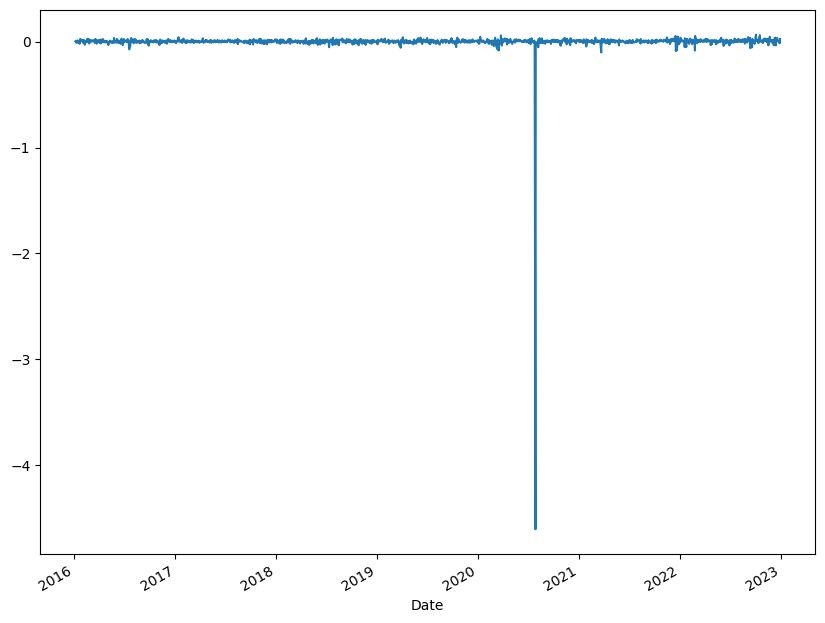

In [137]:
Re.plot(figsize=(10, 8))

In [138]:
max_lag = 30

# AutoReg'i kullanarak modeli sığdırın
model = AutoReg(train, lags=max_lag, trend='n').fit()

# Özeti kullanarak AIC'yi görsel olarak kontrol edebilirsiniz.
print(model.summary())

# AIC değerini programlı olarak almak istiyorsanız
aic_value = model.aic
print("AIC Değeri:", aic_value)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1154
Model:                    AutoReg(30)   Log Likelihood                 636.922
Method:               Conditional MLE   S.D. of innovations              0.137
Date:                Wed, 01 Nov 2023   AIC                          -1211.843
Time:                        12:42:38   BIC                          -1056.079
Sample:                            30   HQIC                         -1152.979
                                 1154                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.0081      0.030      0.271      0.786      -0.050       0.067
y.L2           0.0008      0.030      0.025      0.980      -0.058       0.059
y.L3           0.0066      0.030      0.222      0.8

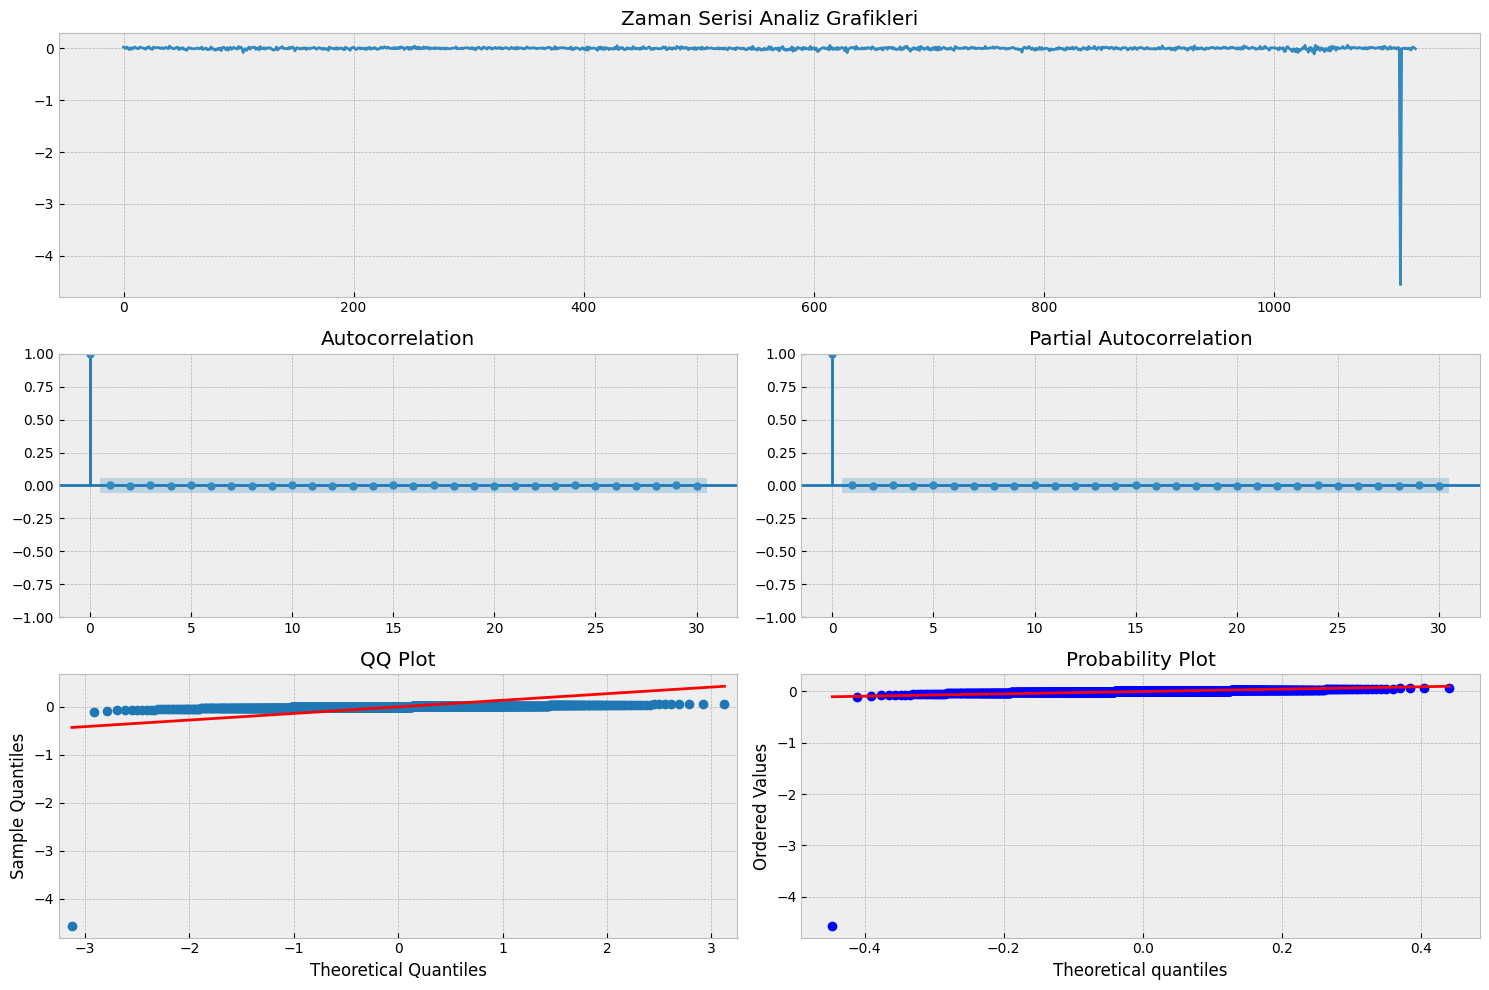

In [139]:
_ = tsplot(model.resid, lags=max_lag)

In [140]:
max_lag = 30
best_aic = np.inf
best_order = 0
best_model = None

# Birden fazla gecikme değeri üzerinde yineleme
for lag in range(1, max_lag + 1):
    model = AutoReg(train, lags=lag, trend='n').fit()
    if model.aic < best_aic:
        best_aic = model.aic
        best_order = lag
        best_model = model

# Sonuçları görüntüle
print('En İyi AR Modeli Sıralaması:', best_order)
print('En İyi AIC Değeri:', best_aic)
print(best_model.summary())

En İyi AR Modeli Sıralaması: 1
En İyi AIC Değeri: -1321.0990790460373
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1154
Model:                     AutoReg(1)   Log Likelihood                 662.550
Method:               Conditional MLE   S.D. of innovations              0.136
Date:                Wed, 01 Nov 2023   AIC                          -1321.099
Time:                        12:42:47   BIC                          -1310.999
Sample:                             1   HQIC                         -1317.287
                                 1154                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.0078      0.029      0.263      0.792      -0.050       0.065
                                    Roots                    

In [141]:
# %95, %99 GA ile 21 günlük SPX getirisi tahmini oluşturun
n_steps = 21

# Tahmin etmek
f = best_model.forecast(steps=n_steps)

# Standart hata (kalıntıların normal olduğu varsayılarak)
std_err = best_model.resid.std()

# %95 GA için güven aralıkları
z_95 = 1.96  # For 95% confidence
lower_ci_95 = f - z_95 * std_err
upper_ci_95 = f + z_95 * std_err

# %99 GA için güven aralıkları
z_99 = 2.576  # %99 güven için
lower_ci_99 = f - z_99 * std_err
upper_ci_99 = f + z_99 * std_err

idx = pd.date_range(df.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame({'forecast': f, 'lower_ci_95': lower_ci_95, 'upper_ci_95': upper_ci_95}, index=idx)
fc_99 = pd.DataFrame({'lower_ci_99': lower_ci_99, 'upper_ci_99': upper_ci_99}, index=idx)

fc_all = fc_95.join(fc_99)
fc_all.head()

forecast  lower_ci_95  upper_ci_95  lower_ci_99  upper_ci_99
2022-12-29      0.00        -0.27         0.27        -0.35         0.35
2022-12-30      0.00        -0.27         0.27        -0.35         0.35
2022-12-31      0.00        -0.27         0.27        -0.35         0.35
2023-01-01      0.00        -0.27         0.27        -0.35         0.35
2023-01-02      0.00        -0.27         0.27        -0.35         0.35

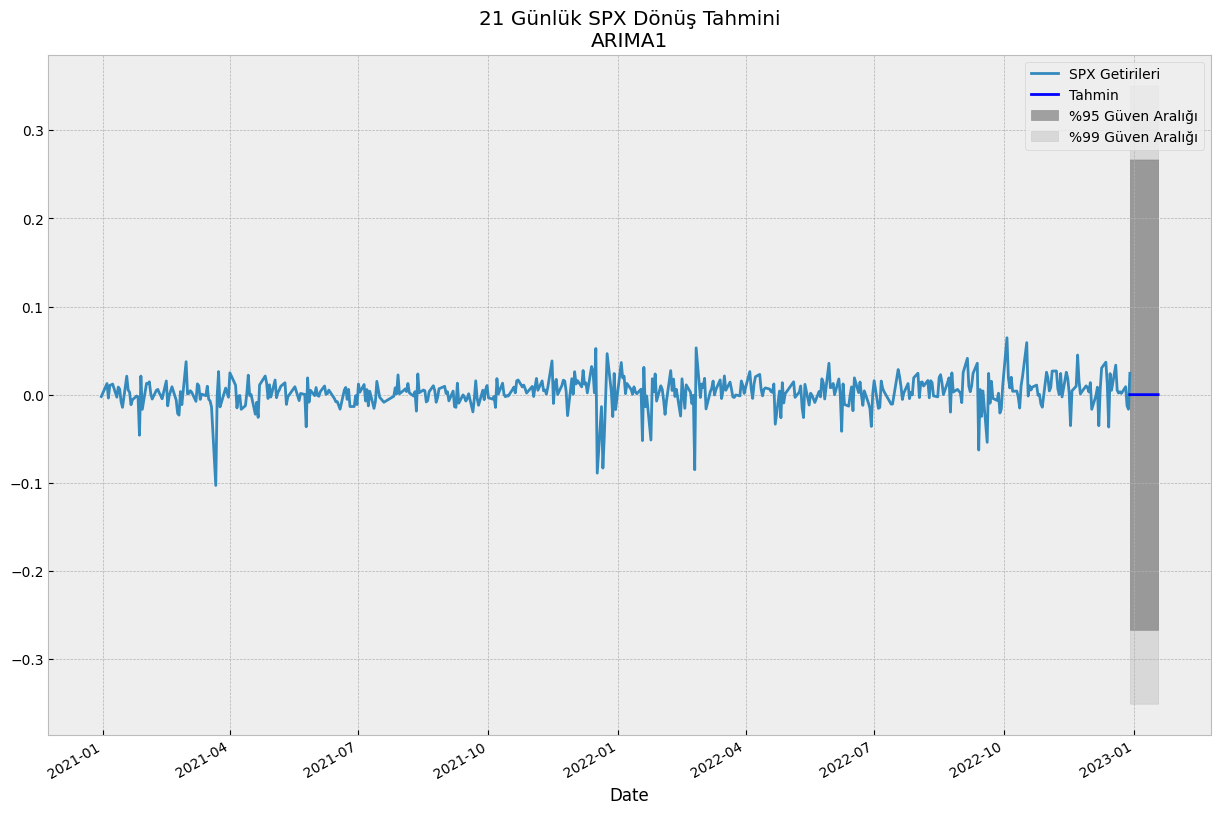

In [142]:
import matplotlib.pyplot as plt

plt.style.use('bmh')

# Şekli ve ekseni başlat
fig, ax = plt.subplots(figsize=(15, 10))

# SPX İadelerinin son 500 gözlemini çizin
Re.iloc[-500:].plot(ax=ax, label='SPX Getirileri')

# Tahmini %95 ve %99 güven aralıklarıyla çizin
fc_all['forecast'].plot(ax=ax, style='b-', label='Tahmin')
ax.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='gray', alpha=0.7, label='%95 Güven Aralığı')
ax.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='gray', alpha=0.2, label='%99 Güven Aralığı')

# Başlığı ve etiketleri ayarlayın
ax.set_title('{} Günlük SPX Dönüş Tahmini\nARIMA{}'.format(n_steps, best_order))
ax.legend(loc='best', fontsize=10)

plt.show()

In [143]:
# tahminlerde bulunmak
predictions = best_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [144]:
test_period = 7
for i in range(test_period):
    print('Tahmin edilen=%f, beklenen=%f'% (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test[:test_period], predictions[:test_period]))

Tahmin edilen=0.000017, beklenen=0.005783
Tahmin edilen=0.000000, beklenen=0.029048
Tahmin edilen=0.000000, beklenen=0.001866
Tahmin edilen=0.000000, beklenen=-0.015112
Tahmin edilen=0.000000, beklenen=-0.001352
Tahmin edilen=0.000000, beklenen=-0.014724
Tahmin edilen=0.000000, beklenen=0.006207


In [145]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.014


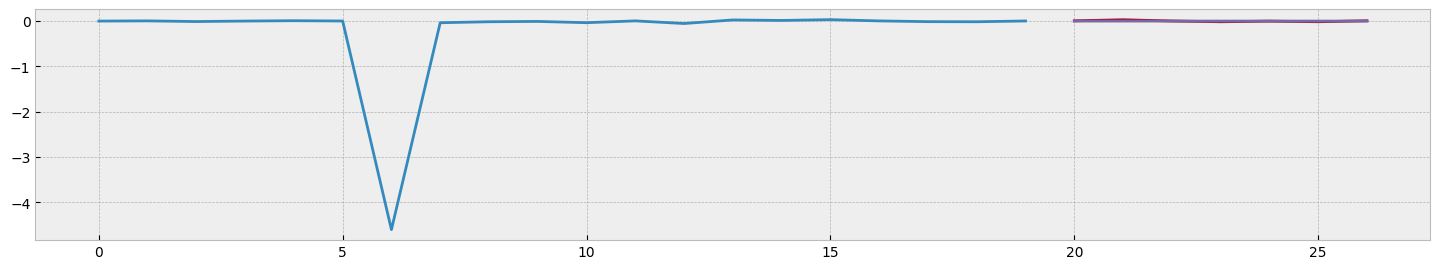

In [146]:
# tahminleri ve beklenen sonuçları test verileri üzerinde çizin
plt.plot(train_y[-20:])
plt.plot([None for i in train_y[-20:]] + [x for x in test_y[:test_period]])
plt.plot([None for i in train_y[-20:]] + [x for x in predictions[:test_period]])

Açıkçası, her gün yeni veriler elde edildikçe modeli yeniden oluşturmak istiyoruz.

## İleriye Doğru Doğrulama

Statsmodels API, yeni gözlemler kullanıma sunuldukça modelin güncellenmesini kolaylaştırmaz. Bunun bir yolu, yeni gözlemler ortaya çıktıkça AR modelini her gün yeniden eğitmek olabilir ve bu, hesaplama açısından pahalı olmasa da geçerli bir yaklaşım olabilir. Bir alternatif, öğrenilen katsayıları kullanmak ve manuel olarak tahminler yapmak olabilir. Bu, önceki gözlemlerin geçmişinin tutulmasını ve katsayıların modelden çıkarılmasını ve yeni tahminler oluşturmak için regresyon denkleminde kullanılmasını gerektirir.

In [147]:
# veri kümesini böl
X = Re.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

In [148]:
# BIC'e göre optimum gecikmeyi belirleyin
best_bic = np.inf
best_lag = None

for lag in range(1, 51):  # kontrol etmek için maksimum 50 gecikme varsayılmaktadır
    model = AutoReg(train, lags=lag)
    result = model.fit()
    if result.bic < best_bic:
        best_bic = result.bic
        best_lag = lag

# En iyi gecikme değerini kullanarak modeli sığdır
model = AutoReg(train, lags=best_lag)
model_fit = model.fit()

window = len(model_fit.model._lags) # Modelde kullanılan gecikmeleri alın
coef = model_fit.params

In [149]:
# testte zaman adımlarında ileri doğru yürüyün
history = list(train[-window:])  # tren setindeki son "pencere" değerleri
predictions = []

for t in test:
    lag = history[-window:]  # son "pencere" gözlemleri
    yhat = coef[0]  # intercept
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    predictions.append(yhat)
    history.append(t)

# RMSE'yi hesaplayın
rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE: ', rmse)

RMSE:  0.01786877967280868


In [150]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.018


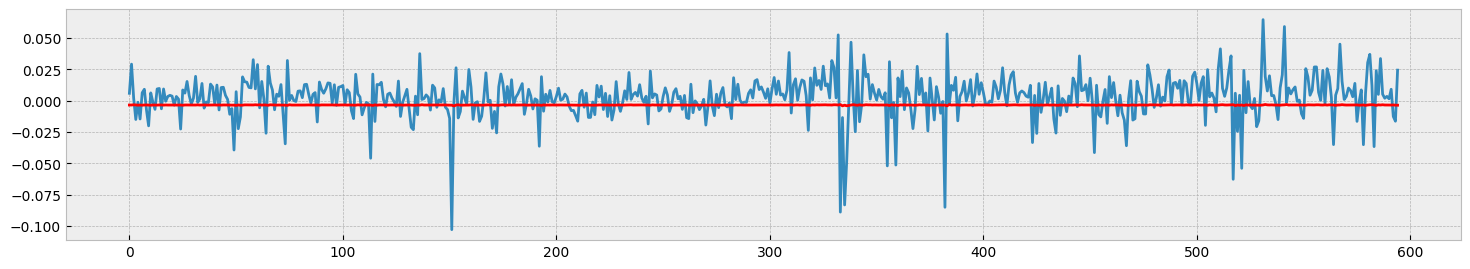

In [151]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')

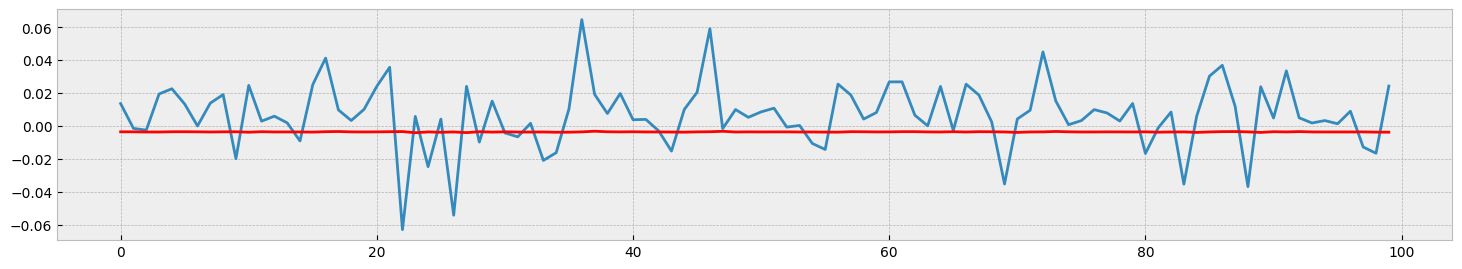

In [152]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

## Tahmin İçin Hareketli Ortalama Modelleri

Beklenen ile tahmin edilen arasındaki farka artık hata denir. Bir zaman serisindeki tahminlerden elde edilen artık hatalar, modelleyebileceğimiz başka bir bilgi kaynağı sağlar. Artık hataların kendisi zamansal yapıya sahip olabilen bir zaman serisi oluşturur. Bu yapının basit bir otoregresyon modeli tahmin hatasını tahmin etmek için kullanılabilir ve bu da tahminleri düzeltmek için kullanılabilir. Bu tür bir modele hareketli ortalama modeli denir; aynı adı taşır ancak hareketli ortalama yumuşatmayla çok farklıdır.


**Artık Hatanın Otoregresyonu**
Artık hata zaman serisini bir otoregresyon modeli kullanarak modelleyebiliriz. Bu, gecikmeli artık hata terimlerinin ağırlıklı doğrusal toplamını oluşturan doğrusal bir regresyon modelidir.
Statsmodels kütüphanesinin sağladığı otoregresyon modelini (AR) kullanabiliriz. Kalıcılık modelini temel alarak (önceki bölüme bakın), ilk önce modeli eğitim veri setinde hesaplanan artık hatalara göre eğitebiliriz.

- MA modelinin motivasyonu, hata sürecindeki "şokları" doğrudan hata terimlerine bir model uydurarak açıklayabilmemizdir. (AR(p) modelinde bu şoklar dolaylı olarak geçmiş gözlemler kullanılarak gözlemlenir)
 
$$x_t=w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$

$w_t$, $E(w_t)=0$ ve varyans $\sigma^2$ ile beyaz gürültü olduğunda

Tanım gereği, k>q için ACF $ρ_k$ sıfır olmalıdır.

In [153]:
# gecikmeli veri kümesi oluştur
values = pd.DataFrame(Re.values)
Re3 = pd.concat([values.shift(1), values], axis=1)
Re3.columns = ['t', 't+1']
Re3 = Re3[1:]
Re3.head()

t   t+1
1  0.00  0.01
2  0.01  0.00
3  0.00 -0.01
4 -0.01  0.01
5  0.01  0.01

In [154]:
# tren ve test setlerine bölünmüş
X = Re3.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [155]:
# eğitim seti üzerinde kalıcılık modeli
train_pred = [x for x in train_X]

In [156]:
# artıkları hesapla
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [157]:
# Eğitim seti artıklarını modelleyin
model = AutoReg(train_resid, lags=1)  # En iyi gecikmeyi seçmek için gecikme sayısını ayarlayabilir veya BIC/AIC gibi yöntemleri kullanabilirsiniz.
model_fit = model.fit()
window = len(model_fit.model._lags)  # Modelde kullanılan gecikme sayısını alın
coef = model_fit.params

In [158]:
print('Lag=%d, Coef=%s' % (window, coef))

Lag=1, Coef=[-1.13269018e-05 -4.97126780e-01]


Otoregresyon modeli önceki 17 zaman adımının artık hatasını gerektirir. Bu nedenle bu değerleri el altında tutmalıyız. Tahminler yaparak ve hatayı tahmin ederek test veri kümesi zaman adımında zaman adım adım ilerlerken, gerçek artık hatayı hesaplayabilir ve artık hata zaman serisi gecikme değerlerini (geçmiş) güncelleyebilir, böylece hatayı bir sonraki zaman adımında hesaplayabiliriz.

In [161]:
# testte zaman adımlarında ileri doğru yürüyün
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions, expected_error = [], []

for t in range(len(test_y)):
    # devamlılık
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)

    # hatayı tahmin etmek
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]

    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    print('tahmin edilen hata=%f, beklenen hata=%f' % (pred_error, error))

tahmin edilen hata=-0.008622, beklenen hata=0.003571
tahmin edilen hata=-0.001787, beklenen hata=0.023264
tahmin edilen hata=-0.011577, beklenen hata=-0.027182
tahmin edilen hata=0.013502, beklenen hata=-0.016977
tahmin edilen hata=0.008429, beklenen hata=0.013759
tahmin edilen hata=-0.006852, beklenen hata=-0.013371
tahmin edilen hata=0.006636, beklenen hata=0.020930
tahmin edilen hata=-0.010416, beklenen hata=0.002761
tahmin edilen hata=-0.001384, beklenen hata=-0.016481
tahmin edilen hata=0.008182, beklenen hata=-0.012678
tahmin edilen hata=0.006291, beklenen hata=0.026292
tahmin edilen hata=-0.013082, beklenen hata=-0.007299
tahmin edilen hata=0.003617, beklenen hata=-0.005838
tahmin edilen hata=0.002891, beklenen hata=0.016285
tahmin edilen hata=-0.008107, beklenen hata=0.000371
tahmin edilen hata=-0.000196, beklenen hata=-0.016206
tahmin edilen hata=0.008045, beklenen hata=0.015813
tahmin edilen hata=-0.007872, beklenen hata=-0.009772
tahmin edilen hata=0.004847, beklenen hata=0.

Bu ileriye dönük bir tahmin veya sürekli bir tahmin modelidir. Tren veri setindeki artık tahmin hatasının ve test veri setindeki tahmin edilen artık hatanın bir zaman serisiyle sonuçlanırız. Bunları çizebilir ve modelin artık hatayı tahmin etmede ne kadar yetenekli olduğuna dair hızlı bir fikir edinebiliriz.

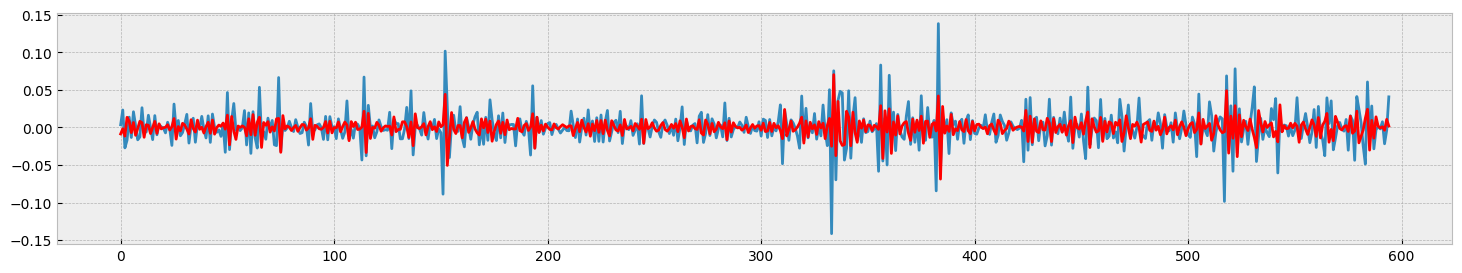

In [162]:
# tahmin edilen hata grafiği
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show()

### Tahmin için ARIMA Modeli

Otoregresif Entegre Hareketli Ortalama Modeli veya kısaca ARIMA, zaman serisi tahmini ve analizi için standart bir istatistiksel modeldir. ARIMA modeli, zaman serisi verilerini analiz etmek ve tahmin etmek için kullanılan bir istatistiksel model sınıfıdır.

ARIMA, Otoregresif Entegre Hareketli Ortalama Modeli anlamına gelen bir kısaltmadır. Bu kısaltma açıklayıcıdır ve modelin temel yönlerini kapsar:

- AR: Otoregresyon. Bir gözlem ile bazı gecikmeli gözlemler arasındaki bağımlı ilişkiyi kullanan bir model.
- Ben: Entegre. Zaman serisini durağan hale getirmek için ham gözlemlerin farkının kullanılması (yani bir gözlemin önceki zaman adımındaki bir gözlemden çıkarılması).
- MA: Hareketli Ortalama. Bir gözlem ile gecikmeli gözlemlere uygulanan hareketli ortalama modelinden kalan hatalar arasındaki bağımlılığı kullanan bir model.

ARIMA modelinin parametreleri şu şekilde tanımlanmıştır:

- p: Modele dahil edilen gecikme gözlemlerinin sayısı, aynı zamanda gecikme sırası olarak da adlandırılır.
- d: Ham gözlemlerin farklılaşma sayısı, aynı zamanda farklılaşma derecesi olarak da adlandırılır.
- q: Hareketli ortalama penceresinin boyutu, aynı zamanda hareketli ortalamanın sırası olarak da adlandırılır.

Basit bir şeyle başlayalım. Şampuan Satışı veri kümesinin tamamına bir ARIMA modeli yerleştireceğiz ve kalan hataları inceleyeceğiz. Öncelikle ARIMA(5,1,0) modelini uyguluyoruz. Bu, otoregresyon için gecikme değerini 5'e ayarlar, zaman serisini durağan hale getirmek için 1'lik bir fark sırası kullanır ve 0'lık bir hareketli ortalama modeli kullanır.





Dolayısıyla ARMA modeli, finansal zaman serilerini modellerken bu hususların her ikisini de yakalamaya çalışır. Bir ARMA modelinin, daha sonra tartışacağımız birçok finansal zaman serisinin temel ampirik fenomeni olan oynaklık kümelenmesini hesaba katmadığını unutmayın.

$$x_t=\alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$

$w_t$, $E(w_t)=0$ ve varyans $\sigma^2$ ile beyaz gürültü olduğunda
Bir ARMA modeli genellikle tek başına AR(p) veya MA(q) modeline göre daha az parametre gerektirir. Yani parametrelerinde fazlalık var

In [163]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(Re, order=(5,1,0))
model_fit = model.fit()

In [164]:
# uyum modelinin özeti
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1750
Model:                 ARIMA(5, 1, 0)   Log Likelihood                1232.262
Date:                Wed, 01 Nov 2023   AIC                          -2452.524
Time:                        12:45:47   BIC                          -2419.723
Sample:                             0   HQIC                         -2440.398
                               - 1750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8297      0.004   -218.339      0.000      -0.837      -0.822
ar.L2         -0.6663      0.005   -138.874      0.000      -0.676      -0.657
ar.L3         -0.5027      0.005    -99.254      0.0

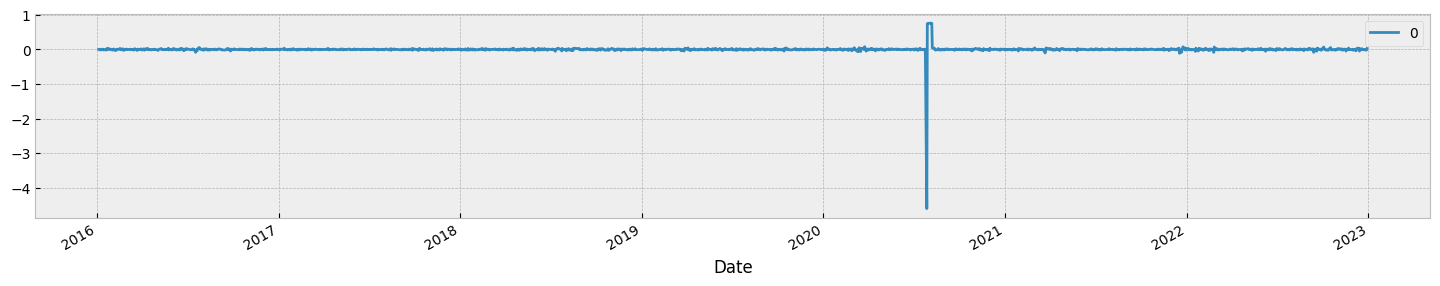

In [165]:
# artıkların çizgi grafiği
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

<Axes: ylabel='Density'>

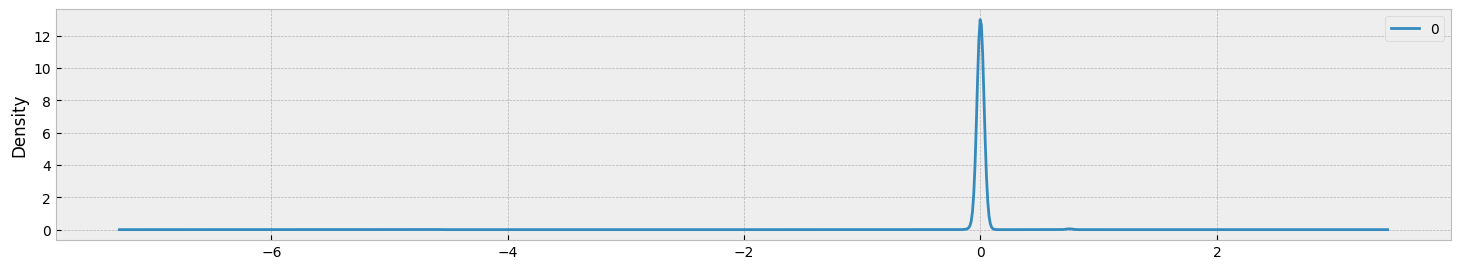

In [166]:
# artıkların yoğunluk grafiği
residuals.plot(kind='kde')

In [167]:
# artıkların özet istatistikleri
residuals.describe()

0
count 1750.00
mean    -0.00
std      0.12
min     -4.60
25%     -0.01
50%     -0.00
75%      0.01
max      0.76

## Sürekli Tahmin ARIMA Modeli

Eğitim veri setini eğitim ve test setlerine bölebilir, modele uyacak şekilde tren setini kullanabilir ve test setindeki her öğe için bir tahmin oluşturabiliriz.

In [168]:
# tren ve test setlerine bölünmüş
X = Re.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [169]:
from tqdm import tqdm

# walk-forward validation
total_tests = len(test)

# Bir ilerleme çubuğu göstermek amacıyla aralığı sarmak için tqdm'yi kullanma
for t in tqdm(range(total_tests), desc="İşlem", ncols=100):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

İşlem: 100%|██████████████████████████████████████████████████████| 595/595 [01:58<00:00,  5.01it/s]


In [170]:
# tahminleri değerlendir
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.018


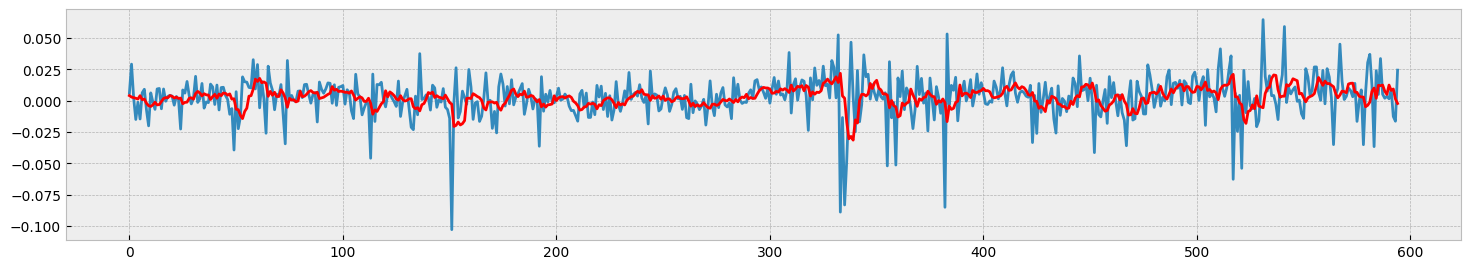

In [171]:
# Gerçek sonuçlara karşı tahminleri planlayın
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red')

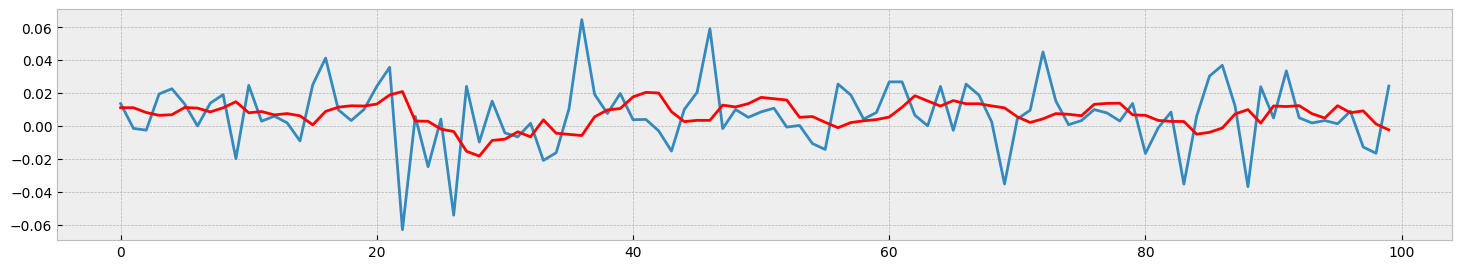

In [172]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

## Izgara Arama ARIMA Modeli Hiperparametreleri

In [173]:
from tqdm import tqdm

# belirli bir sipariş için bir ARIMA modelini değerlendirin (p,d,q)
def evaluate_arima_model(X, arima_order):
    # eğitim veri kümesini hazırlamak
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # tahminlerde bulunmak
    predictions = list()
    
    # ilerleme çubuğu için tqdm ile sarma aralığı
    for t in tqdm(range(len(test)), desc="Tahmin"):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit() 
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # numune hatasını hesapla
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# parametreleri değerlendir
p = 3
d = 1
q = 0
order = (p, d, q)
evaluate_arima_model(Re.values, order)

Tahmin: 100%|██████████| 595/595 [00:45<00:00, 13.00it/s]


0.018474789610064626

In [174]:
# ARIMA modeli için p, d ve q değerlerinin kombinasyonlarını değerlendirin
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('En iyi ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [175]:
# parametreleri değerlendir
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]

evaluate_models(Re.values, p_values, d_values, q_values)

Tahmin: 100%|██████████| 595/595 [01:11<00:00,  8.28it/s]


ARIMA(0, 0, 0) RMSE=0.018


Tahmin: 100%|██████████| 595/595 [01:42<00:00,  5.82it/s]


ARIMA(0, 0, 1) RMSE=0.017


Tahmin: 100%|██████████| 595/595 [00:33<00:00, 17.80it/s]


ARIMA(0, 1, 0) RMSE=0.024


Tahmin: 100%|██████████| 595/595 [02:35<00:00,  3.83it/s]


ARIMA(0, 1, 1) RMSE=0.018


Tahmin: 100%|██████████| 595/595 [01:53<00:00,  5.22it/s]


ARIMA(1, 0, 0) RMSE=0.017


Tahmin: 100%|██████████| 595/595 [01:20<00:00,  7.42it/s]


ARIMA(1, 0, 1) RMSE=0.017


Tahmin: 100%|██████████| 595/595 [00:21<00:00, 27.42it/s]


ARIMA(1, 1, 0) RMSE=0.020


Tahmin: 100%|██████████| 595/595 [03:58<00:00,  2.49it/s]


ARIMA(1, 1, 1) RMSE=0.018


Tahmin: 100%|██████████| 595/595 [02:35<00:00,  3.82it/s]


ARIMA(2, 0, 0) RMSE=0.017


Tahmin: 100%|██████████| 595/595 [03:45<00:00,  2.63it/s]


ARIMA(2, 0, 1) RMSE=0.017


Tahmin: 100%|██████████| 595/595 [00:32<00:00, 18.16it/s]


ARIMA(2, 1, 0) RMSE=0.019


Tahmin: 100%|██████████| 595/595 [05:29<00:00,  1.81it/s]

ARIMA(2, 1, 1) RMSE=0.018
En iyi ARIMA(2, 0, 1) RMSE=0.017


## ARCH ve GARCH modelleri

Bu bölümde, bizi ARCH olarak bilinen ilk koşullu değişken varyans modelimize yönlendiren koşullu değişken varyansı tartışacağız. Daha sonra ARCH'e yapılan uzantıları tartışacağız ve bu da bizi GARCH(p,q) olarak da bilinen, p,q mertebesindeki ünlü Genelleştirilmiş Otoregresif Koşullu Değişken Varyans modeline götürecektir. GARCH, birçok varlık fiyatının koşullu değişen varyanslı olması nedeniyle finans sektöründe yaygın olarak kullanılmaktadır.

### Koşullu Değişen Varyans

Finansta koşullu değişen varyansın incelenmesinin ana motivasyonu, varlık getirilerinin oynaklığıdır. Rastgele değişkenlerden oluşan bir koleksiyon, daha büyük bir küme içinde geri kalan değişkenlerden farklı bir varyansa sahip belirli değişken grupları veya alt kümeleri varsa, heteroskedastiktir.

Finansta, varyanstaki bir artış, varyansın daha da artmasıyla ilişkilendirilebilir. Örneğin, hisse senedi piyasalarının önemli bir düşüş yaşadığı bir günde, yalnızca uzun portföylerdeki otomatik risk yönetimi satış emirleri tetiklenir, bu da bu portföylerdeki hisse senedi fiyatlarının daha da düşmesine yol açarak önemli ölçüde aşağı yönlü volatiliteye yol açar.

Bu "satış" dönemleri ve diğer birçok volatilite biçimi, seri olarak ilişkili olan ve dolayısıyla artan varyans dönemlerine bağlı olan değişen varyanslara yol açar. Dolayısıyla bu tür serilerin koşullu heteroskedastik olduğunu söylüyoruz.

Koşullu heteroskedastik serilerin zorlayıcı yönlerinden biri, volatiliteye sahip bir serinin ACF grafiklerinin hala durağan ayrık beyaz gürültünün bir gerçekleşmesi gibi görünebilmesidir. Bu, serinin zaman içinde varyansının sabit olmaması nedeniyle kesinlikle durağan olmamasına rağmen geçerlidir.
CH'yi modelimize dahil etmek için, varyansın kendisi için otoregresif bir süreç kullanan bir model oluşturabiliriz; aslında varyansın geçmiş değerlerini kullanarak zaman içinde varyansta meydana gelen değişiklikleri açıklayan bir model.
Bu, Otoregresif Koşullu Heteroskedastic (ARCH) modelinin temelidir.
Otoregresif Koşullu Heteroskedastic Modeller - ARCH(p)

ARCH(p) modelleri basitçe bir zaman serisinin varyansına uygulanan bir AR(p) modeli olarak düşünülebilir.
$$Var(\epsilon_t) = \alpha_0 + \alpha_1Var(\epsilon_{t-1})+…+\alpha_pVar(\epsilon_{t-p})+w_t$$
Gerçek zaman serisi şu şekilde verilir:
$$\epsilon_t = w_t\sqrt{\alpha_0 + \alpha_1\epsilon_{t-1}^2+…+\alpha_p\epsilon_{t-p}^2}$$
ARCH(1) için bu şu şekildedir: $$\epsilon_t = w_t\sqrt{\alpha_0+\alpha_1\epsilon_{t-1}^2}$$

ARCH(p) Ne Zaman Uygulanmalı?

Bir AR(p) modeli uydurmaya çalıştığımızda ve serinin ACF grafiğinde $p$ gecikmesinin azalmasıyla ilgilendiğimizde, aynı mantığı artıkların karesine de uygulayabiliriz. Bu kare artıklara bir AR(p) uygulayabileceğimizi bulursak, o zaman bir ARCH(p) sürecinin uygun olabileceğine dair bir göstergeye sahip oluruz.
ARCH(p)'nin yalnızca artıkların ayrı beyaz gürültü gibi görünmesini sağlayacak kadar uygun bir modelin zaten takıldığı bir seriye uygulanması gerektiğini unutmayın. ARCH'nin uygun olup olmadığını yalnızca artıkların karesini alarak ve ACF'yi inceleyerek söyleyebileceğimiz için, artıkların ortalamasının sıfır olduğundan da emin olmamız gerekir.
ARCH yalnızca herhangi bir eğilimi veya mevsimsel etkisi olmayan, yani (belirgin) seri korelasyonu olmayan serilere uygulanmalıdır. ARIMA genellikle böyle bir seriye uygulanır ve bu noktada ARCH iyi bir seçim olabilir.

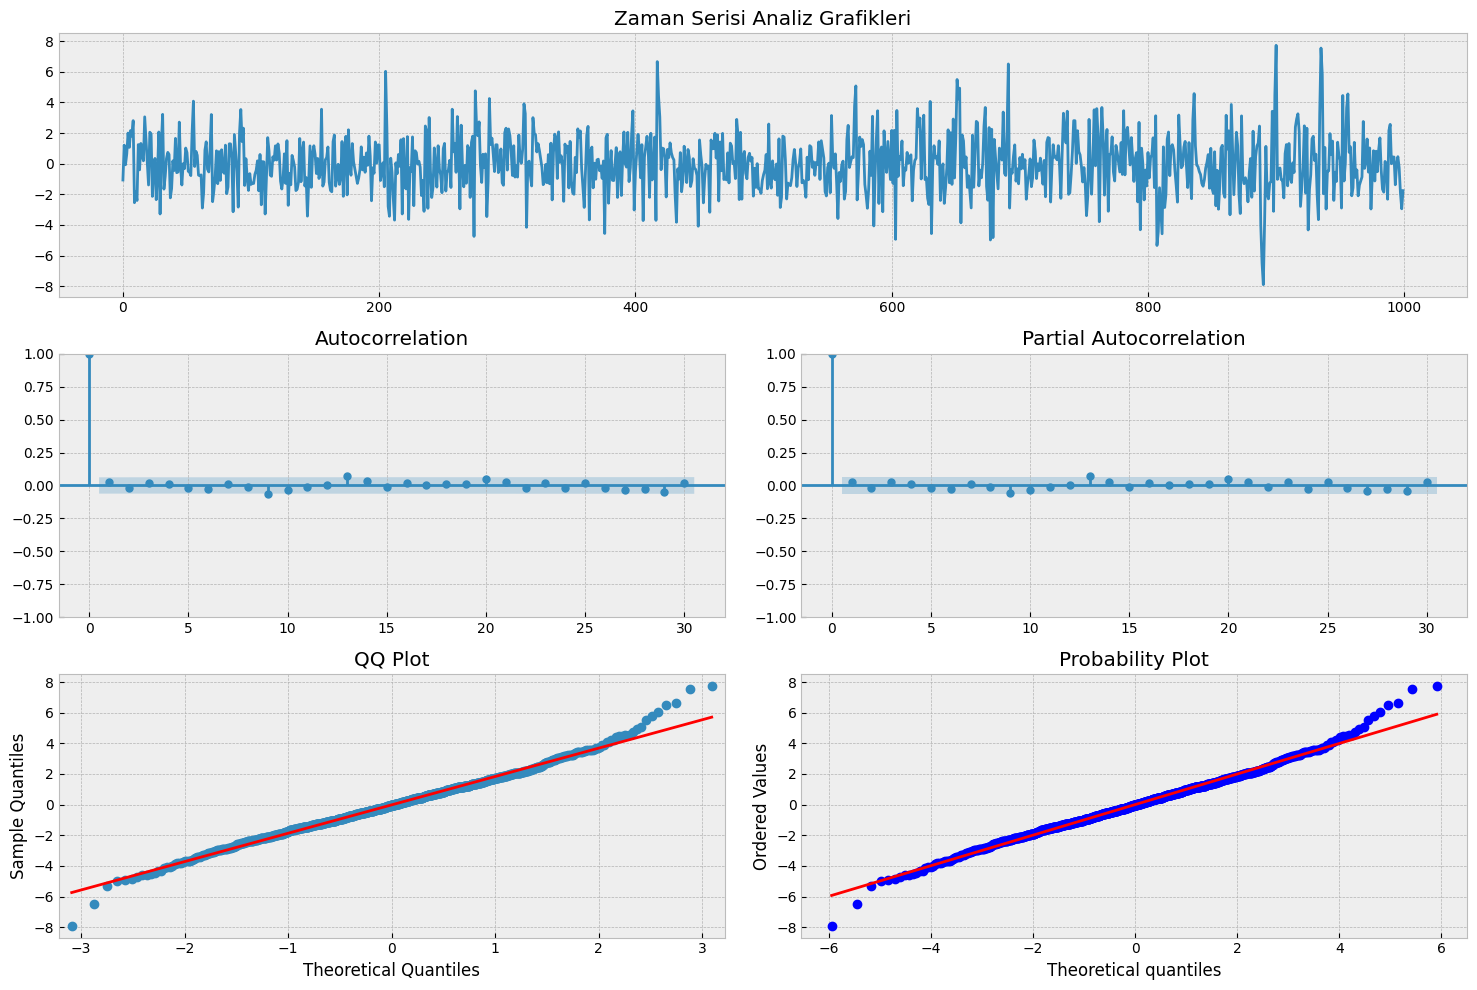

In [176]:
# ARCH(1) serisini simüle edin
# Var(yt) = a_0 + a_1*y{t-1}**2
# eğer a_1 0 ile 1 arasındaysa yt beyaz gürültüdür

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simüle edilmiş ARCH(1) serisi, beyaz gürültüye benziyor
tsplot(y, lags=30)

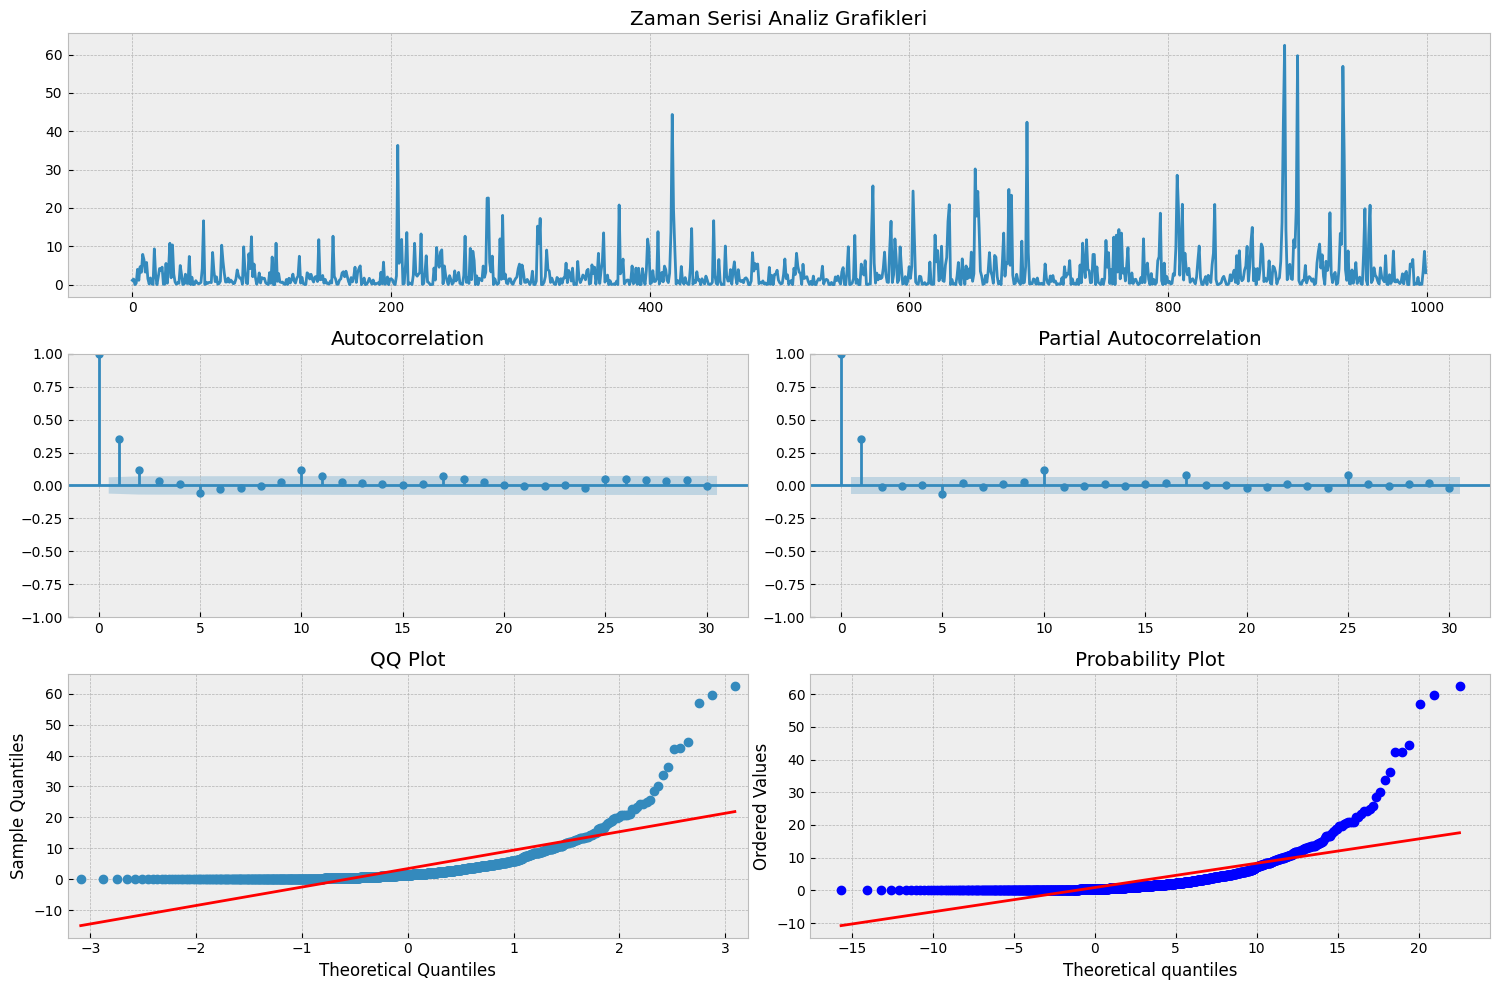

In [177]:
tsplot(y**2, lags=30)

Zaman serisinin tıpkı beyaz gürültüye benzediğine dikkat edin. Ancak serinin karesini çizdiğimizde ACF ve PACF'nin 1. gecikmede anlamlılık gösterdiği görülüyor ve varyans için AR(1) modelinin uygun olabileceğini gösteriyor.
Bu aşamada sorulması gereken bariz soru, varyansa AR(p) sürecini uygulayacaksak neden Hareketli Ortalama MA(q) modelini de uygulamamamızdır? Veya ARMA(p,q) gibi karma bir model mi?
Bu aslında GARCH olarak bilinen Genelleştirilmiş ARCH modelinin motivasyonudur.
Genelleştirilmiş Otoregresif Koşullu Heteroskedastic Modeller - GARCH(p,q)
GARCH(p, q), bir zaman serisinin varyansına uygulanan bir ARMA modelidir; yani bir otoregresif terime ve bir hareketli ortalama terime sahiptir. AR(p), artıkların varyansını (hataların karesi) veya basitçe zaman serimizin karesini modeller. MA(q) kısmı sürecin varyansını modeller.

$$\epsilon_t = \sigma_t w_t$$

Burada $w_t$ sıfır ortalama ve birim varyansa sahip ayrık beyaz gürültüdür ve $\sigma^2$ şu şekilde verilir:

$$\sigma_t^2=\alpha_0+\sum_{i=1}^{p}\alpha_i\epsilon_{t-i}^2+\sum_{j=1}^{q}\beta_j\sigma_{t-j}^2 $$

Burada $\alpha_i$ ve $\beta_j$ modelin parametreleridir. GARCH(1,1) için $\sigma^2$ şöyledir:

$$\sigma_t^2=\alpha_0+\alpha_1\epsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$

$\alpha_1 + \beta_1$ 1'den küçük olmalıdır, aksi takdirde model kararsız olur. Aşağıda bir GARCH(1, 1) sürecini simüle edebiliriz.

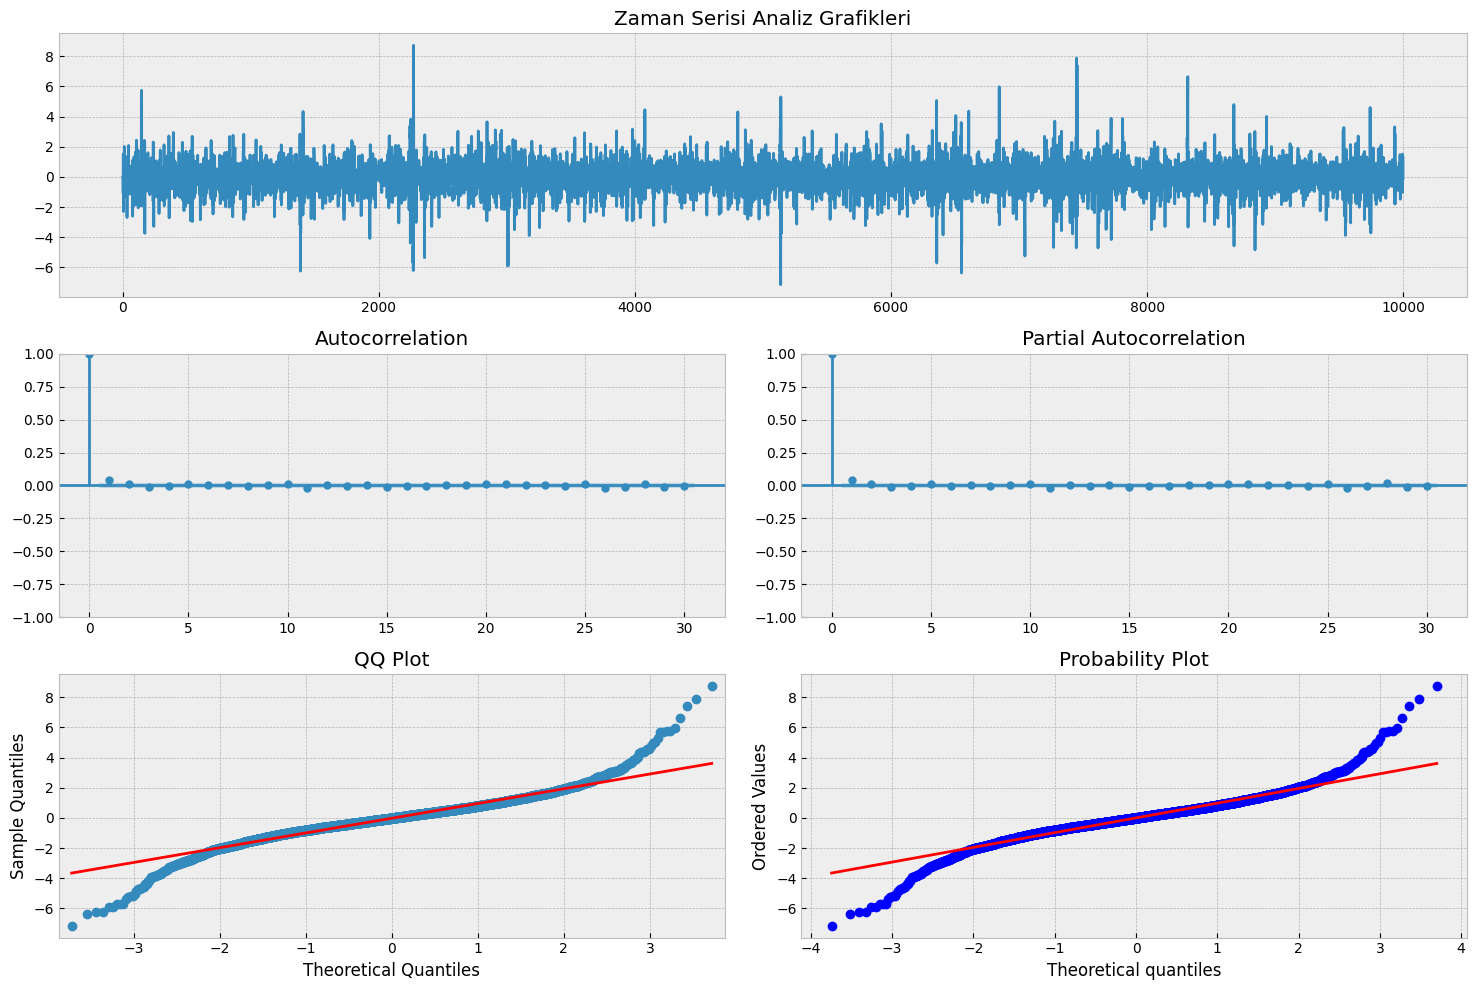

In [178]:
# GARCH(1, 1) sürecini simüle etme

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

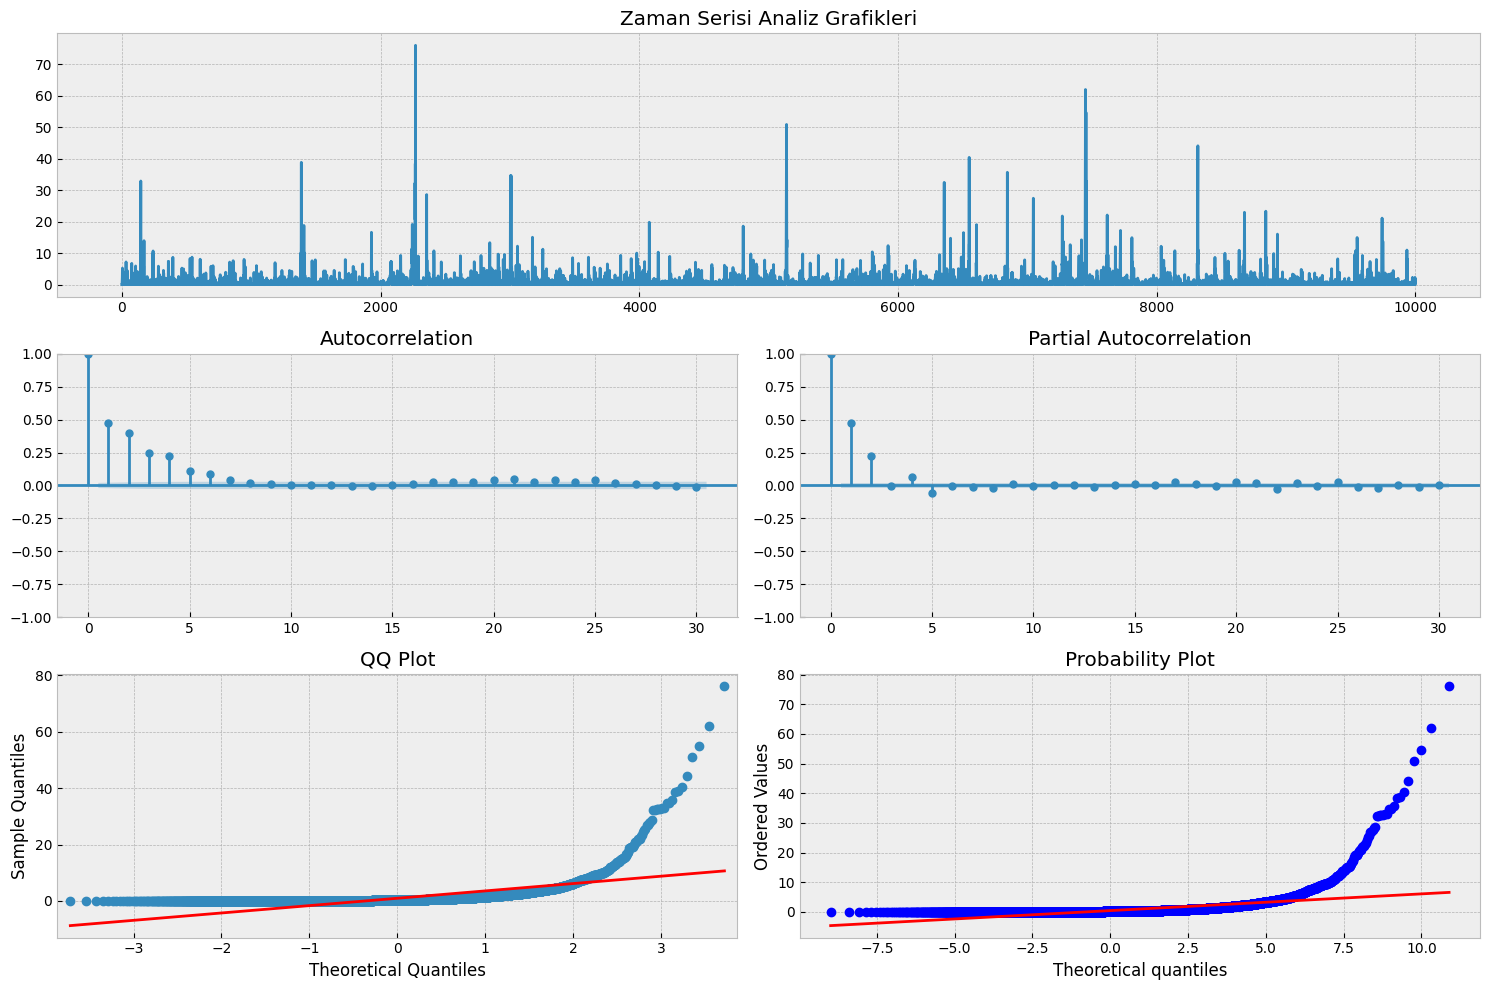

In [179]:
_ = tsplot(eps**2, lags=30)

In [180]:
# Simüle edilmiş EPS serimize bir GARCH(1, 1) modeli yerleştirin
# ARCH paketindeki arch_model fonksiyonunu kullanıyoruz

#! pip install arch
from arch import arch_model

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.789119756882
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.312782262137
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267318166
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Wed, Nov 01 2023   Df Residuals:                     9999
Time:       

### Finansal Zaman Serilerine Uygulama

Şimdi prosedürü bir finansal zaman serisine uygulayın. Burada SPX getirilerini kullanacağız. Süreç aşağıdaki gibidir:
Zaman serimize en iyi şekilde uyacak şekilde ARIMA(p, d, q) modellerinin kombinasyonlarını yineleyin.
GARCH modeli siparişlerini en düşük AIC'ye sahip ARIMA modeline göre seçin.
GARCH(p, q) modelini zaman serimize yerleştirin.
Otokorelasyon için model artıklarını ve karesi alınmış artıkları inceleyin
Burada öncelikle SPX dönüşünü bir ARIMA sürecine sığdırmaya ve en iyi düzeni bulmaya çalışıyoruz.

In [181]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = Re
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)
res_tup = _get_best_model(TS)

aic:    inf | order: None


In [182]:
order = res_tup[1]
model = res_tup[2]

Artıkların beyaz gürültüye benzediğini görüyoruz. Artıkların karesine bakalım

Kareli artıklarda otokorelasyonun açık kanıtlarını görebiliriz. Bir GARCH modeli yerleştirelim ve nasıl çalıştığını görelim.

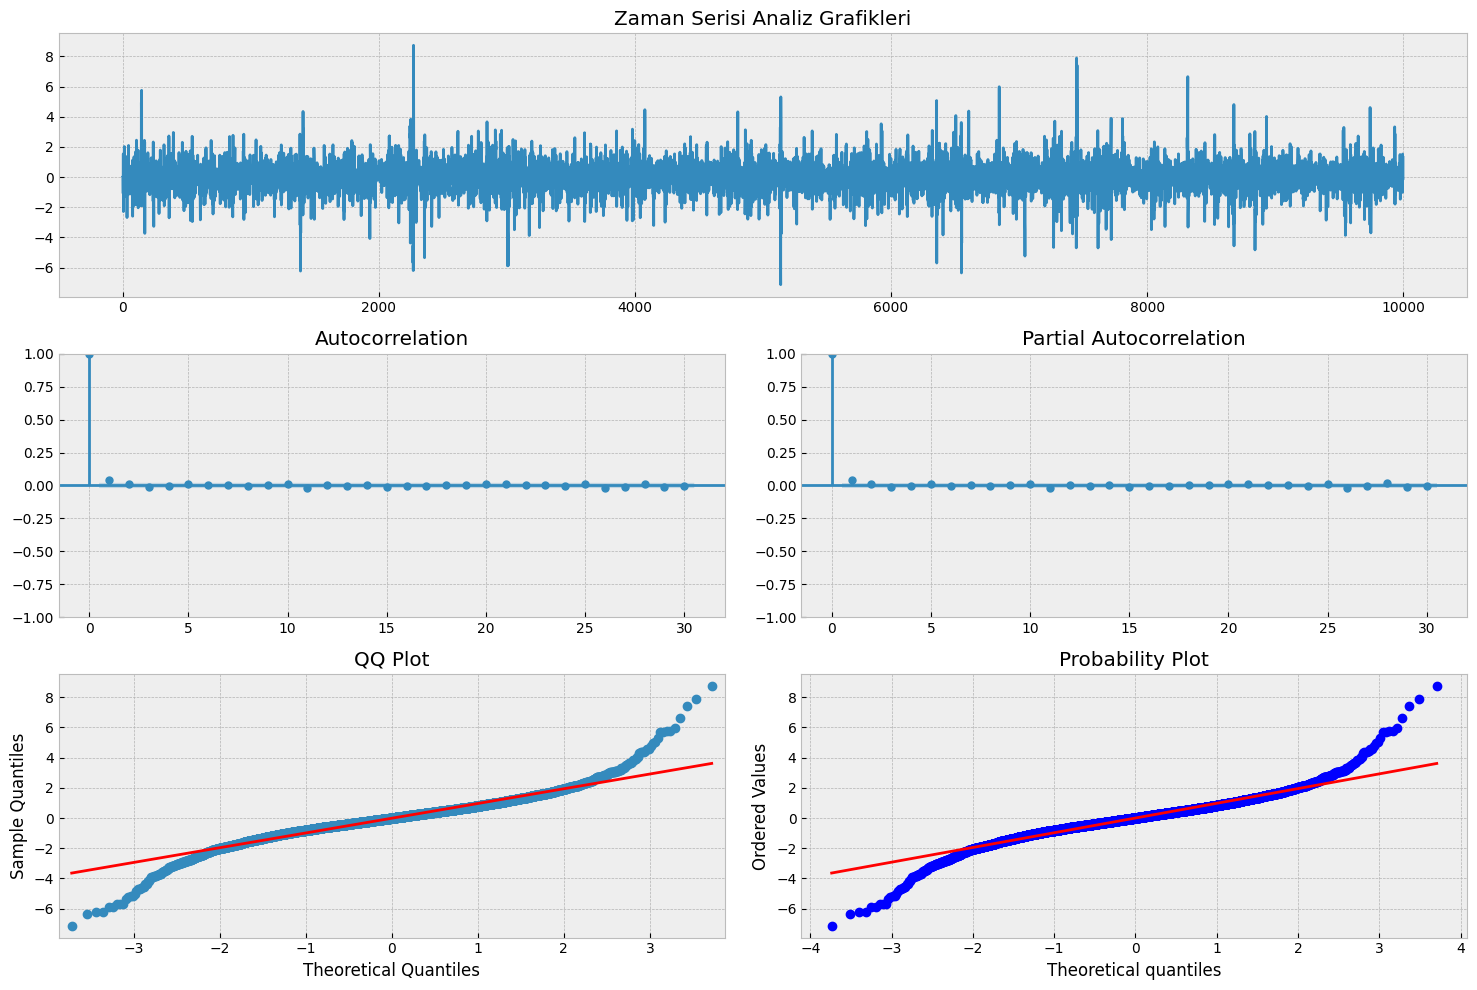

In [183]:
tsplot(res.resid, lags=30)

Grafikler, ayrı bir beyaz gürültü sürecinin gerçekleştirilmesine benziyor ve bu da iyi bir uyumun göstergesi. Emin olmak için artıkların karesini çizelim

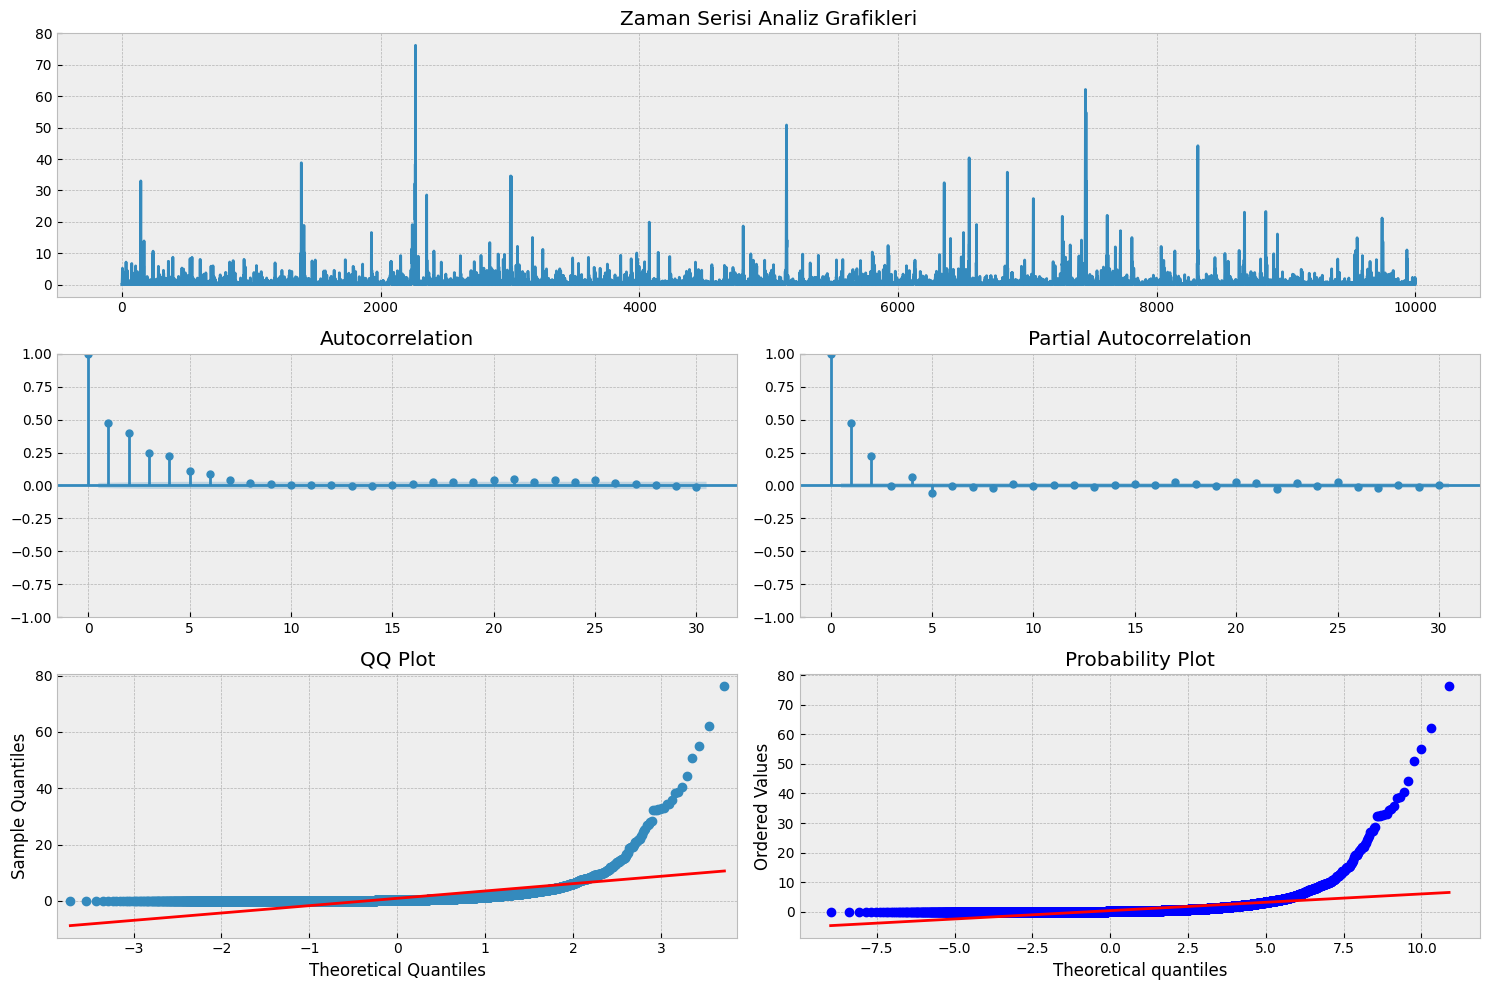

In [184]:
tsplot(res.resid**2, lags=30)

## BİST100 Endeksi'nde ARIMA+GARCH Ticaret Stratejisi

## Stratejiye Genel Bakış

Bu stratejinin fikri aşağıdaki gibidir:

- Her $n$ günü için, optimal bir ARIMA ve GARCH modeline uyacak şekilde S&P 500'ün önceki $k$ günlerine ait farklı logaritmik getirilerini kullanın.

- Bir sonraki günün getirileri hakkında tahminde bulunmak için birleştirilmiş modeli kullanın

- Tahmin olumluysa, hisse senedinde uzun pozisyon açın ve olumsuzsa, hisse senedini $n_{th}$ gün kapanışından açık pozisyona getirin

- Tahmin önceki günle aynıysa hiçbir şey yapmayın

$k=500$ ile çalışacağız ancak bu, performansı artırmak veya düşümü azaltmak için optimize edilebilecek bir parametredir.

**Not: Geriye dönük test, komisyonu veya kaymayı hesaba katmaz; dolayısıyla gerçek bir ticaret sisteminde elde edilen performans, burada gördüğünüzden daha düşük olacaktır.**

 ### Strateji uygulama

import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [185]:
start = datetime.datetime(2006,1,1)
end = datetime.datetime(2020,6,30)
df = yf.download("XU100.IS", start=start, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [186]:
df.head()

Date
2006-01-02   39790.70
2006-01-03   40665.40
2006-01-04   41362.50
2006-01-05   41722.40
2006-01-06   41905.40
Name: Adj Close, dtype: float64

In [187]:
lrets = np.log(df/df.shift(1)).fillna(0)
lrets.index = pd.DatetimeIndex(lrets.index.values,freq=lrets.index.inferred_freq)

In [188]:
lrets.head()

2006-01-02   0.00
2006-01-03   0.02
2006-01-04   0.02
2006-01-05   0.01
2006-01-06   0.00
Name: Adj Close, dtype: float64

In [189]:
windowLength = 252
foreLength = len(lrets) - windowLength

In [190]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1,4) # [1,2,3]
    for i in pq_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,0,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, 0, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: %6.5f | order: %s'%(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

Bu aşamada, ticaret verilerinde her gün döngü yapmamız ve $k=500$ uzunluğundaki kayan pencereye uygun bir ARIMA ve GARCH modelini yerleştirmemiz gerekiyor. Her gün için 32 ayrı ARIMA uyumu denediğimiz ve bir GARCH modeli yerleştirdiğimiz göz önüne alındığında, göstergenin oluşturulması uzun zaman alabilir.

### Strateji Sonuçları
Artık sinyallerimizi oluşturduğumuza göre performansını "Al ve Tut" ile karşılaştırmamız gerekiyor.

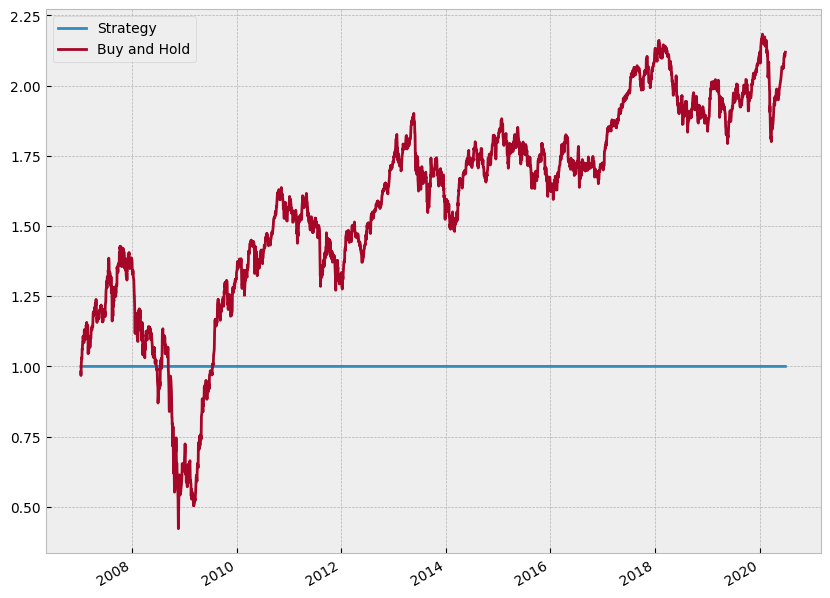

In [192]:
rets = pd.DataFrame(index = signal.index, columns=['Buy and Hold', 'Strategy'])
rets['Buy and Hold'] = lrets[-foreLength:]
rets['Strategy'] = signal
rets['Strategy'] = rets['Strategy']*rets['Buy and Hold']

eqCurves = pd.DataFrame(index = signal.index, columns=['Buy and Hold', 'Strategy'])
eqCurves['Buy and Hold']=rets['Buy and Hold'].cumsum()+1
eqCurves['Strategy'] = rets['Strategy'].cumsum()+1
eqCurves['Strategy'].plot(figsize=(10,8))
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()